# Emotion recognition

In [3]:
import pandas as pd
import numpy as np
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from matplotlib.pyplot import imshow
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
import random as rn
from tensorflow.keras import layers
from keras import callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [4]:
os.environ["PYTHONHASHSEED"]="0"
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

## Utility Functions

In [61]:
def evaluate_model(model, X_val_bal, y_val_bal):
    y_score = model.predict(X_val_bal)
    y_true = y_val_bal

    print("Classification report: ")
    print(classification_report(y_true, np.argmax(y_score, axis=1), digits=4))

    n_classes = y_score.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
        roc_auc[i] = roc_auc_score(y_true == i, y_score[:, i])

    plt.figure(figsize=(10, 6))
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'pink', 'brown']

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f'ROC curve for Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [62]:
def plot_evaluation(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Load the data

In [63]:
zip_file_path = '/Users/marysia/Downloads/face_data.zip'
extracted_folder_path = '/Users/marysia/My_Projects/IS_Project'

In [64]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [65]:
data_splitted_path = '/Users/marysia/My_Projects/IS_Project/Images'

train_dir = os.path.join(data_splitted_path, 'train')
validation_dir = os.path.join(data_splitted_path, 'validation')

train_happy_dir = os.path.join(train_dir, 'Happy')
train_sad_dir = os.path.join(train_dir, 'Sad')
train_angry_dir = os.path.join(train_dir, 'Angry')
train_disgust_dir = os.path.join(train_dir, 'Disgust')
train_fear_dir = os.path.join(train_dir, 'Fear')
train_neutral_dir = os.path.join(train_dir, 'Neutral')
train_surprise_dir = os.path.join(train_dir, 'Surprise')

validation_happy_dir = os.path.join(validation_dir, 'Happy')
validation_sad_dir = os.path.join(validation_dir, 'Sad')
validation_angry_dir = os.path.join(validation_dir, 'Angry')
validation_disgust_dir = os.path.join(validation_dir, 'Disgust')
validation_fear_dir = os.path.join(validation_dir, 'Fear')
validation_neutral_dir = os.path.join(validation_dir, 'Neutral')
validation_surprise_dir = os.path.join(validation_dir, 'Surprise')

In [66]:
num_happy_tr = len(os.listdir(train_happy_dir))
num_sad_tr = len(os.listdir(train_sad_dir))
num_angry_tr = len(os.listdir(train_angry_dir))
num_disgust_tr = len(os.listdir(train_disgust_dir))
num_fear_tr = len(os.listdir(train_fear_dir))
num_neutral_tr = len(os.listdir(train_neutral_dir))
num_surprise_tr = len(os.listdir(train_surprise_dir))

num_happy_val = len(os.listdir(validation_happy_dir))
num_sad_val = len(os.listdir(validation_sad_dir))
num_angry_val = len(os.listdir(validation_angry_dir))
num_disgust_val = len(os.listdir(validation_disgust_dir))
num_fear_val = len(os.listdir(validation_fear_dir))
num_neutral_val = len(os.listdir(validation_neutral_dir))
num_surprise_val = len(os.listdir(validation_surprise_dir))

total_train = num_angry_tr + num_happy_tr + num_sad_tr + num_disgust_tr + num_fear_tr + num_neutral_tr +num_surprise_tr
total_val = num_happy_val + num_sad_val + num_angry_val + num_disgust_val + num_fear_val + num_neutral_val +num_surprise_val

In [67]:
print('total training happy images:', num_happy_tr)
print('total training sad images:', num_sad_tr)
print('total training angry images:', num_angry_tr)
print('total training disgust images:', num_disgust_tr)
print('total training fear images:', num_fear_tr)
print('total training neutral images:', num_neutral_tr)
print('total training suprise images:', num_surprise_tr)

print()

print('total validation happy images:', num_happy_val)
print('total validation sad images:', num_sad_val)
print('total validation angry images:', num_angry_val)
print('total validation disgust images:', num_disgust_val)
print('total validation fear images:', num_fear_val)
print('total validation neutral images:', num_neutral_val)
print('total validation suprise images:', num_surprise_val)

print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training happy images: 7215
total training sad images: 4830
total training angry images: 3995
total training disgust images: 436
total training fear images: 4097
total training neutral images: 4965
total training suprise images: 3171

total validation happy images: 879
total validation sad images: 594
total validation angry images: 491
total validation disgust images: 55
total validation fear images: 528
total validation neutral images: 626
total validation suprise images: 416
--
Total training images: 28709
Total validation images: 3589


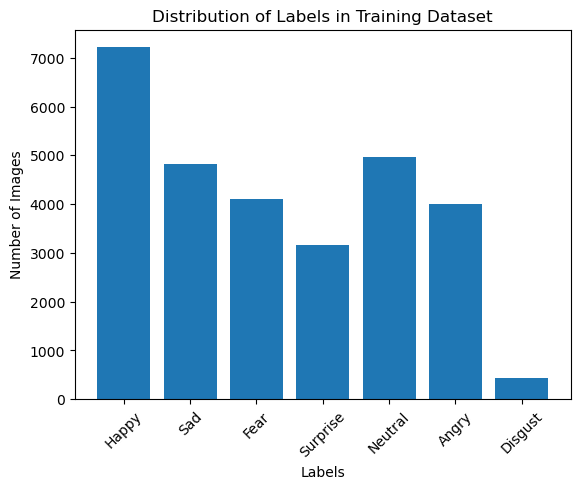

Class 'Happy' has 7215 images.
Class 'Sad' has 4830 images.
Class 'Fear' has 4097 images.
Class 'Surprise' has 3171 images.
Class 'Neutral' has 4965 images.
Class 'Angry' has 3995 images.
Class 'Disgust' has 436 images.


In [68]:
# Subdirectories (categories) in the train directory
train_subdirs = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

# Initialize dictionaries to store label counts
train_label_counts = {}

# Count the number of images in each label/category
for label in train_subdirs:
    label_dir = os.path.join(train_dir, label)
    num_images = len(os.listdir(label_dir))
    train_label_counts[label] = num_images

# Plot histogram
plt.bar(train_label_counts.keys(), train_label_counts.values())
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Distribution of Labels in Training Dataset')
plt.xticks(rotation=45)
plt.show()

for label, count in train_label_counts.items():
    print(f"Class '{label}' has {count} images.")

The dataset are **imbalanced**. The most numerous class is Happy, which is around 25% of whole dataset, while the least numerous class in Disgust, which is around 1% of whole dataset.

## Data preprocessing

Create the new directory with equal number of images for each class (manually undersampling) and split data to train, validation and test sets.

In [69]:
# Source directory containing images
source_dir = '/Users/marysia/My_Projects/IS_Project/Images'  

# Target directory to create new folders
target_dir = '/Users/marysia/My_Projects/IS_Project/Images2'  

# The number of images in each new folder
desired_num_images_per_folder = 436  

# Subdirectories (categories) in the source directory
source_subdirs = [label for label in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, label))]

# Create new folders and move images
for label in source_subdirs:
    source_label_dir = os.path.join(source_dir, label)
    target_label_dir = os.path.join(target_dir, label)

    # Create the target directory if it doesn't exist
    os.makedirs(target_label_dir, exist_ok=True)

    # List all image files in the source directory
    image_files = [file for file in os.listdir(source_label_dir) if file.endswith('.jpg')]  
    
    # Shuffle the list of image files (optional)
    random.shuffle(image_files)

    # Move the desired number of images to the target directory
    num_images_to_move = min(len(image_files), desired_num_images_per_folder)
    images_to_move = image_files[:num_images_to_move]

    for image in images_to_move:
        source_image_path = os.path.join(source_label_dir, image)
        target_image_path = os.path.join(target_label_dir, image)
        shutil.move(source_image_path, target_image_path)

print("Images moved and new folders created.")

Images moved and new folders created.


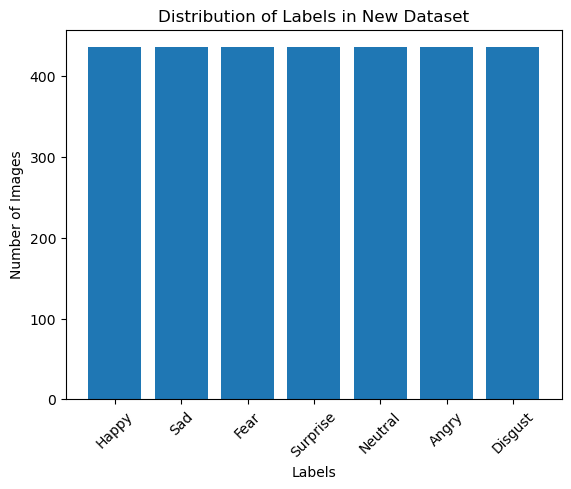

Class 'Happy' has 436 images.
Class 'Sad' has 436 images.
Class 'Fear' has 436 images.
Class 'Surprise' has 436 images.
Class 'Neutral' has 436 images.
Class 'Angry' has 436 images.
Class 'Disgust' has 436 images.


In [135]:
target_subdirs = [label for label in os.listdir(target_dir) if os.path.isdir(os.path.join(target_dir, label))]

# Initialize dictionaries to store label counts and directories to delete
target_label_counts = {}
dirs_to_delete = []

target_subdirs.remove('.ipynb_checkpoints')
target_subdirs.remove('train')
target_subdirs.remove('test')
target_subdirs.remove('validation')

# Count the number of images in each label/category and identify directories to delete
for label in target_subdirs:
    label_dir = os.path.join(target_dir, label)
    num_images = len(os.listdir(label_dir))
    target_label_counts[label] = num_images

    # Check if the directory has 0 images, and mark it for deletion
    if num_images == 0:
        dirs_to_delete.append(label_dir)

# Remove directories with 0 images from the list of subdirectories
target_subdirs = [label for label in target_subdirs if label not in dirs_to_delete]

# Plot histogram for non-empty directories
plt.bar(target_label_counts.keys(), target_label_counts.values())
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Distribution of Labels in New Dataset')
plt.xticks(rotation=45)
plt.show()

# Print the remaining label counts
for label, count in target_label_counts.items():
    print(f"Class '{label}' has {count} images.")

In [26]:
import os
import shutil
import random

# Define the source directory containing your data
source_dir = '/Users/marysia/My_Projects/IS_Project/Images2'  # Replace with your actual source directory path

# Define the output directory where the split data will be saved
output_dir = '/Users/marysia/My_Projects/IS_Project/Images3'  # Replace with your desired output directory path

# Define the split ratios (e.g., 80% train, 10% validation, 10% test)
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Create "train," "validation," and "test" directories if they don't exist
train_dir = os.path.join(output_dir, "train")
validation_dir = os.path.join(output_dir, "validation")
test_dir = os.path.join(output_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all files in the source directory (recursively)
file_list = []
for root, dirs, files in os.walk(source_dir):
    for file_name in files:
        file_list.append(os.path.join(root, file_name))

random.shuffle(file_list)

# Calculate the number of files for each split
total_files = len(file_list)
num_train = int(total_files * train_ratio)
num_validation = int(total_files * validation_ratio)
num_test = total_files - num_train - num_validation

# Copy files to their respective splits
for i, source_file_path in enumerate(file_list):
    if i < num_train:
        target_file_path = os.path.join(train_dir, os.path.relpath(source_file_path, source_dir))
    elif i < num_train + num_validation:
        target_file_path = os.path.join(validation_dir, os.path.relpath(source_file_path, source_dir))
    else:
        target_file_path = os.path.join(test_dir, os.path.relpath(source_file_path, source_dir))

    os.makedirs(os.path.dirname(target_file_path), exist_ok=True)
    shutil.copy2(source_file_path, target_file_path)

print("Data split into 'train,' 'validation,' and 'test' directories.")

Data split into 'train,' 'validation,' and 'test' directories.


In [31]:
data_splitted_path = output_dir

In [29]:
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180
BATCH_SIZE = 128

In [40]:
train_dataset = image_dataset_from_directory(
    os.path.join(data_splitted_path, 'train'),
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    os.path.join(data_splitted_path, 'validation'),
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    os.path.join(data_splitted_path, 'test'),
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 2441 files belonging to 7 classes.
Found 305 files belonging to 7 classes.
Found 306 files belonging to 7 classes.


In [33]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 180, 180, 3)
labels batch shape: (128,)


In [41]:
X_test = []
y_test = []

for images, labels in test_dataset:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

## Build the network

In [34]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(7, activation="softmax")(x)
model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [35]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [36]:
model_1.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy']) 

In [37]:
history_1 = model_1.fit(train_dataset, 
                              epochs=30, 
                              batch_size=BATCH_SIZE,
                              validation_data = validation_dataset, # evaluate the generalization capability of our model 
                              shuffle = True)

Epoch 1/30


2023-09-11 14:14:58.043812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 1.9534 - accuracy: 0.1422

2023-09-11 14:15:08.605200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 11s 448ms/step - loss: 1.9534 - accuracy: 0.1422 - val_loss: 1.9454 - val_accuracy: 0.1738
Epoch 2/30
20/20 [==============================] - 6s 318ms/step - loss: 1.9464 - accuracy: 0.1405 - val_loss: 1.9441 - val_accuracy: 0.1344
Epoch 3/30
20/20 [==============================] - 7s 322ms/step - loss: 1.9397 - accuracy: 0.1639 - val_loss: 1.9300 - val_accuracy: 0.2361
Epoch 4/30
20/20 [==============================] - 6s 312ms/step - loss: 1.9128 - accuracy: 0.1856 - val_loss: 1.8500 - val_accuracy: 0.2459
Epoch 5/30
20/20 [==============================] - 6s 310ms/step - loss: 1.8673 - accuracy: 0.2491 - val_loss: 1.8350 - val_accuracy: 0.2393
Epoch 6/30
20/20 [==============================] - 6s 312ms/step - loss: 1.8213 - accuracy: 0.2716 - val_loss: 1.7991 - val_accuracy: 0.2852
Epoch 7/30
20/20 [==============================] - 6s 311ms/step - loss: 1.7652 - accuracy: 0.3097 - val_loss: 1.7505 - val_accuracy: 0.2984
Epoch 8/30
20/20

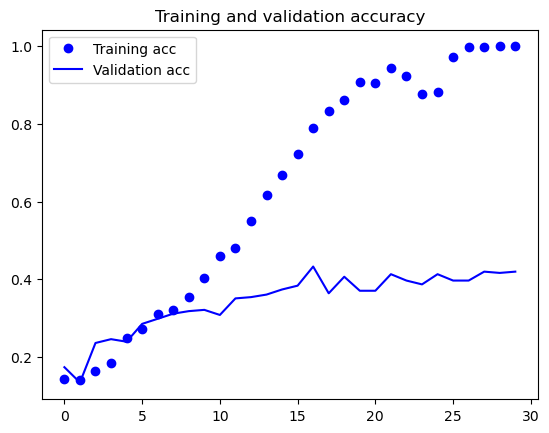

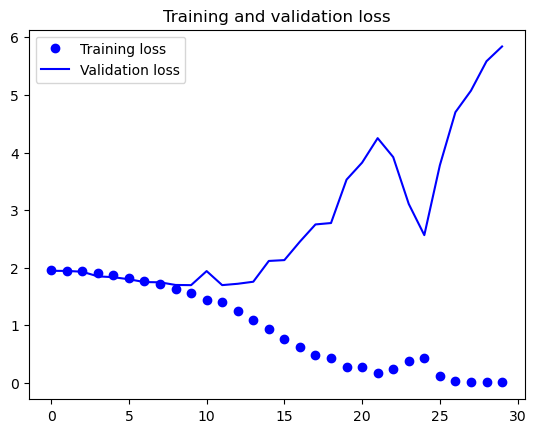

In [38]:
plot_evaluation(history_1)

Based on the plot of training and validation accuracy and loss, it can be concluded that the model has started to overfit.

 3/10 [========>.....................] - ETA: 0s

2023-09-11 14:21:20.734111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 54ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.3077    0.3265    0.3168        49
           1     0.5102    0.6410    0.5682        39
           2     0.1778    0.2353    0.2025        34
           3     0.4500    0.4186    0.4337        43
           4     0.3696    0.3333    0.3505        51
           5     0.2571    0.2571    0.2571        35
           6     0.5897    0.4182    0.4894        55

    accuracy                         0.3791       306
   macro avg     0.3803    0.3757    0.3740       306
weighted avg     0.3943    0.3791    0.3824       306



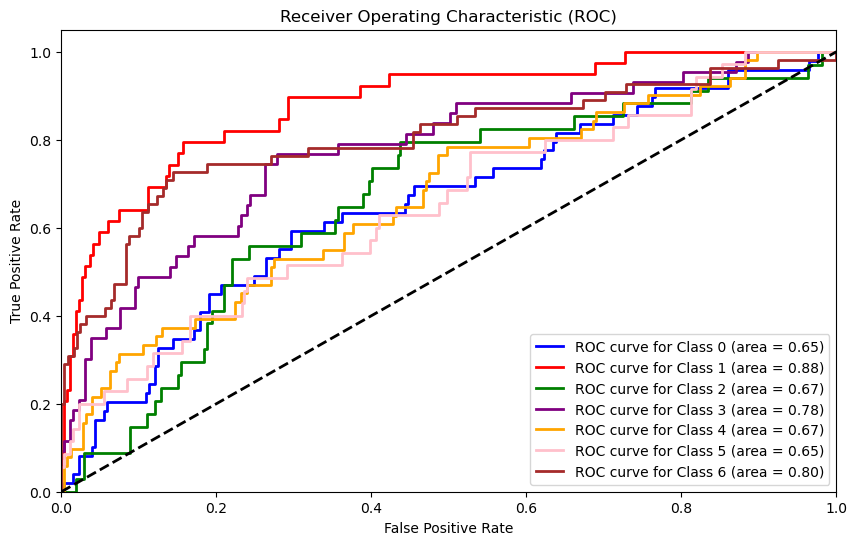

In [42]:
# Call the evaluate_model function with your model and data
evaluate_model(model_1, X_test, y_test)

The model achived the best results for class 1 (AUC = 0.88) and the lowest performance for class 0 and 5 (AUC = 0.65).

# Prevent overfitting
This section will describe trails of improving the model performance.

## 1. Early Stopping

In [44]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history_11 = model_1.fit(train_dataset, 
                            epochs=30, 
                            batch_size=BATCH_SIZE,
                            validation_data = validation_dataset, # evaluate the generalization capability of our model
                            callbacks=[callback],
                            shuffle = True)

Epoch 1/30
20/20 [==============================] - 7s 317ms/step - loss: 0.0100 - accuracy: 0.9992 - val_loss: 5.9535 - val_accuracy: 0.4131
Epoch 2/30
20/20 [==============================] - 7s 330ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 6.0258 - val_accuracy: 0.4098
Epoch 3/30
20/20 [==============================] - 7s 329ms/step - loss: 0.0079 - accuracy: 0.9992 - val_loss: 6.0380 - val_accuracy: 0.4197
Epoch 4/30
20/20 [==============================] - 7s 341ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 6.1798 - val_accuracy: 0.4066


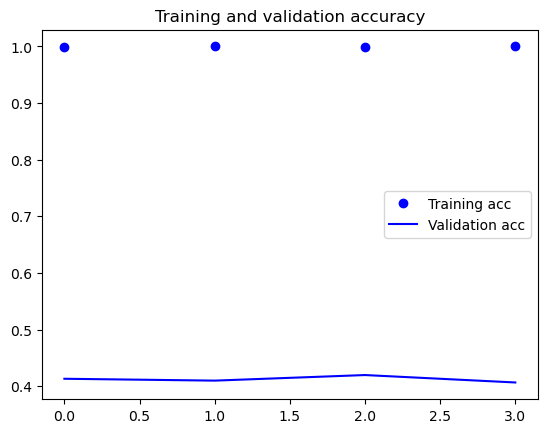

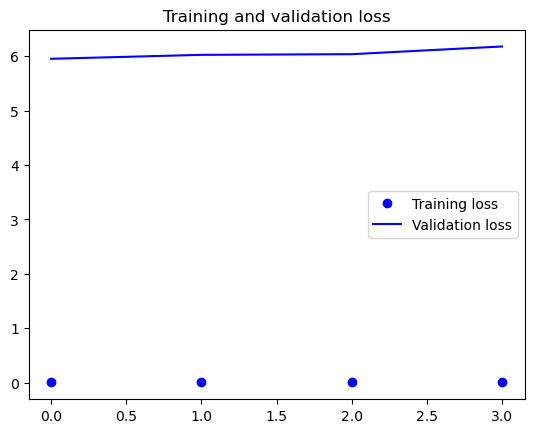

In [45]:
plot_evaluation(history_11)

10/10 [==============================] - 0s 29ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.3077    0.3265    0.3168        49
           1     0.5625    0.6923    0.6207        39
           2     0.1778    0.2353    0.2025        34
           3     0.4222    0.4419    0.4318        43
           4     0.3750    0.2941    0.3297        51
           5     0.2105    0.2286    0.2192        35
           6     0.6316    0.4364    0.5161        55

    accuracy                         0.3824       306
   macro avg     0.3839    0.3793    0.3767       306
weighted avg     0.4001    0.3824    0.3858       306



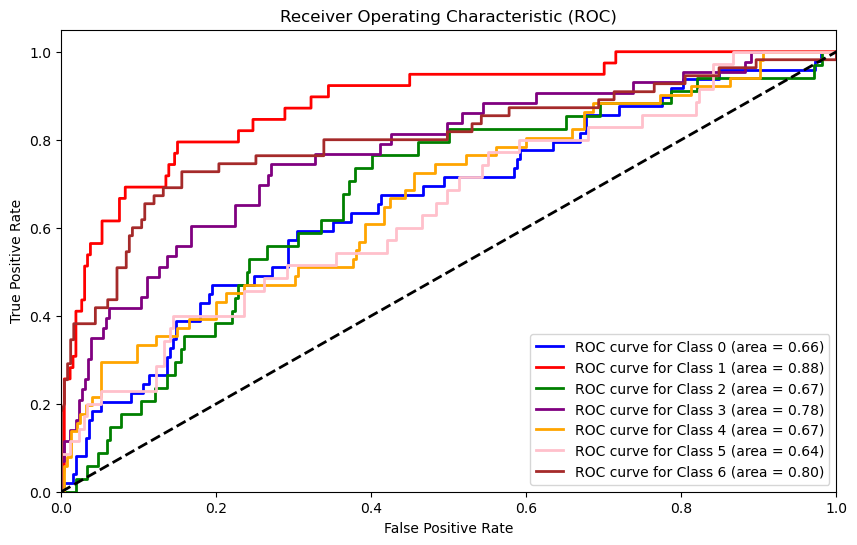

In [48]:
# Call the evaluate_model function with your model and data
evaluate_model(model_1, X_test, y_test)

## 2. Data Augumentation

In [49]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.1), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.2), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
])

2023-09-11 14:28:54.437903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-11 14:28:55.000345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-11 14:28:55.113389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-11 14:28:55.213818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-11 14:28:55.314321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-11 14:28:55.409443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

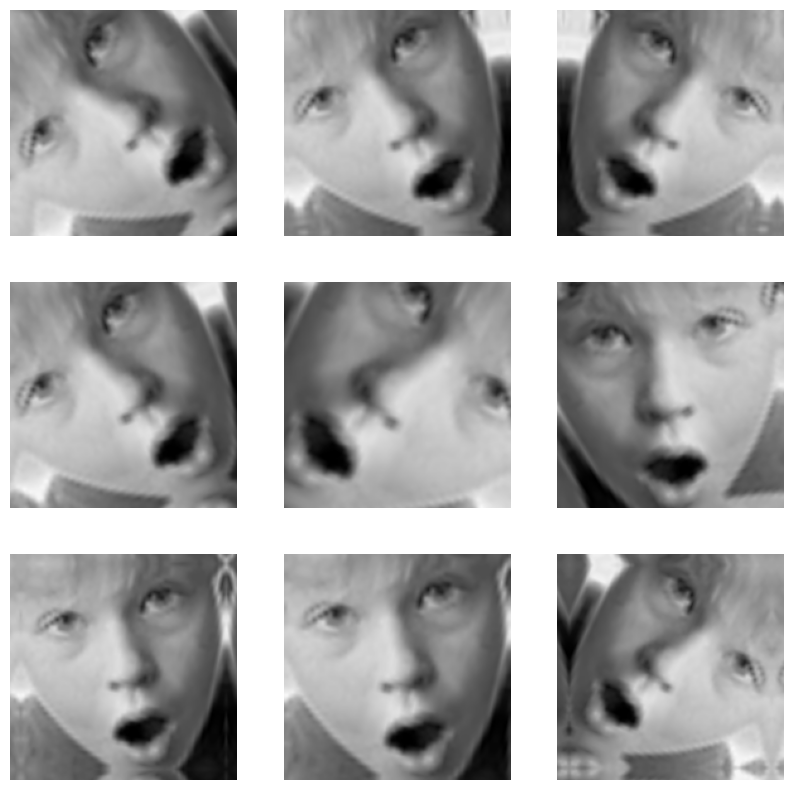

In [50]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [51]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(7, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [52]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

In [53]:
model_2.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy']) 

In [56]:
history_2 = model_2.fit(train_dataset, 
                        epochs=30, 
                        batch_size=BATCH_SIZE,
                        validation_data = validation_dataset, # evaluate the generalization capability of our model 
                        shuffle = True)

Epoch 1/30
20/20 [==============================] - 7s 320ms/step - loss: 1.6900 - accuracy: 0.3343 - val_loss: 1.6980 - val_accuracy: 0.3213
Epoch 2/30
20/20 [==============================] - 6s 318ms/step - loss: 1.6253 - accuracy: 0.3785 - val_loss: 1.7445 - val_accuracy: 0.2918
Epoch 3/30
20/20 [==============================] - 6s 317ms/step - loss: 1.5462 - accuracy: 0.4228 - val_loss: 1.7129 - val_accuracy: 0.3541
Epoch 4/30
20/20 [==============================] - 7s 327ms/step - loss: 1.4417 - accuracy: 0.4592 - val_loss: 1.7333 - val_accuracy: 0.3869
Epoch 5/30
20/20 [==============================] - 7s 333ms/step - loss: 1.3556 - accuracy: 0.5023 - val_loss: 1.7401 - val_accuracy: 0.3770
Epoch 6/30
20/20 [==============================] - 7s 362ms/step - loss: 1.2023 - accuracy: 0.5641 - val_loss: 1.8405 - val_accuracy: 0.3639
Epoch 7/30
20/20 [==============================] - 8s 393ms/step - loss: 1.0718 - accuracy: 0.6034 - val_loss: 1.8440 - val_accuracy: 0.3836
Epoch 

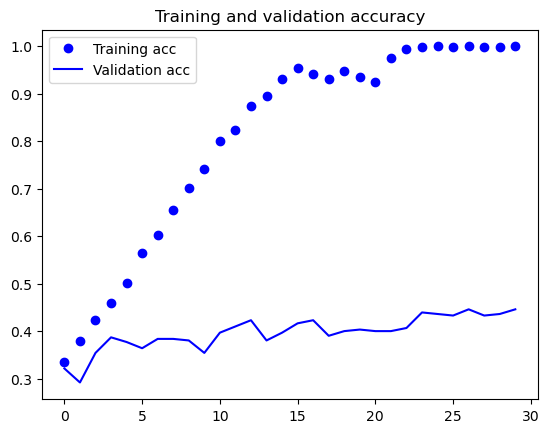

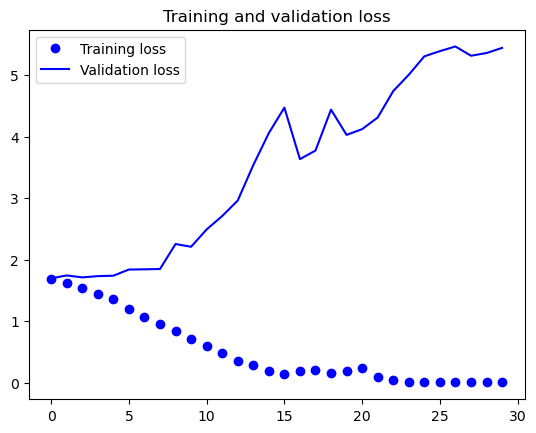

In [71]:
plot_evaluation(history_2)

 1/10 [==>...........................] - ETA: 2s

2023-09-11 14:51:48.965778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 25ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.1957    0.1837    0.1895        49
           1     0.4902    0.6410    0.5556        39
           2     0.1190    0.1471    0.1316        34
           3     0.3571    0.3488    0.3529        43
           4     0.3077    0.3137    0.3107        51
           5     0.1892    0.2000    0.1944        35
           6     0.7778    0.5091    0.6154        55

    accuracy                         0.3431       306
   macro avg     0.3481    0.3348    0.3357       306
weighted avg     0.3699    0.3431    0.3500       306



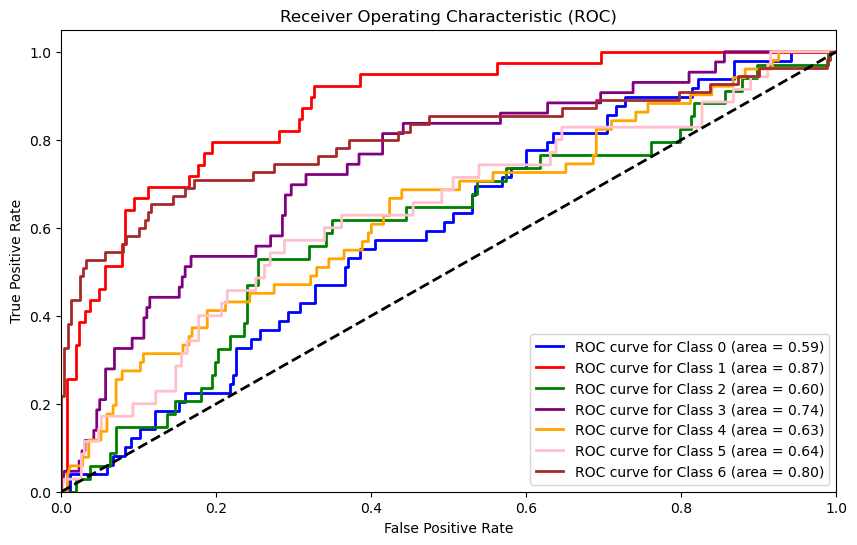

In [72]:
evaluate_model(model_2, X_test, y_test)

## 3. Dropoutlayer

In [80]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(7, activation="softmax")(x)

model_3 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [81]:
model_3.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy']) 

In [82]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [83]:
history_3 = model_3.fit(train_dataset, 
                        epochs=30, 
                        batch_size=BATCH_SIZE,
                        validation_data = validation_dataset, # evaluate the generalization capability of our model
                        shuffle = True,
                        verbose=1)

Epoch 1/30


2023-09-11 15:16:17.411865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 15:16:17.675804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 30s - loss: 1.9500 - accuracy: 0.1250

2023-09-11 15:16:18.663799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 14s - loss: 1.9676 - accuracy: 0.1367

2023-09-11 15:16:19.550631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 12s - loss: 1.9614 - accuracy: 0.1406

2023-09-11 15:16:20.078852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 10s - loss: 1.9605 - accuracy: 0.1348

2023-09-11 15:16:20.522882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 8s - loss: 1.9585 - accuracy: 0.1406 

2023-09-11 15:16:20.925680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 7s - loss: 1.9543 - accuracy: 0.1497

2023-09-11 15:16:21.329187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 6s - loss: 1.9539 - accuracy: 0.1462

2023-09-11 15:16:21.728642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 6s - loss: 1.9548 - accuracy: 0.1406

2023-09-11 15:16:22.121545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 5s - loss: 1.9537 - accuracy: 0.1432

2023-09-11 15:16:22.524554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 4s - loss: 1.9529 - accuracy: 0.1422

2023-09-11 15:16:22.913241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 4s - loss: 1.9522 - accuracy: 0.1442

2023-09-11 15:16:23.320644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 3s - loss: 1.9517 - accuracy: 0.1413

2023-09-11 15:16:23.710791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 3s - loss: 1.9514 - accuracy: 0.1430

2023-09-11 15:16:24.097961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 2s - loss: 1.9510 - accuracy: 0.1440

2023-09-11 15:16:24.496172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 1.9506 - accuracy: 0.1432

2023-09-11 15:16:24.895631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 1s - loss: 1.9506 - accuracy: 0.1406

2023-09-11 15:16:25.285762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9505 - accuracy: 0.1374

2023-09-11 15:16:25.673937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 0s - loss: 1.9502 - accuracy: 0.1372

2023-09-11 15:16:26.067864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/20 [===========================>..] - ETA: 0s - loss: 1.9500 - accuracy: 0.1373

2023-09-11 15:16:26.492200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9500 - accuracy: 0.1376

2023-09-11 15:16:26.844851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 10s 453ms/step - loss: 1.9500 - accuracy: 0.1376 - val_loss: 1.9457 - val_accuracy: 0.1639
Epoch 2/30


2023-09-11 15:16:27.208587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 8s - loss: 1.9437 - accuracy: 0.1641

2023-09-11 15:16:27.675322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 7s - loss: 1.9441 - accuracy: 0.1250

2023-09-11 15:16:28.075248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 6s - loss: 1.9461 - accuracy: 0.1250

2023-09-11 15:16:28.493444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 6s - loss: 1.9471 - accuracy: 0.1387

2023-09-11 15:16:28.901635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 6s - loss: 1.9483 - accuracy: 0.1391

2023-09-11 15:16:29.295312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 5s - loss: 1.9468 - accuracy: 0.1393

2023-09-11 15:16:29.701953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 5s - loss: 1.9467 - accuracy: 0.1440

2023-09-11 15:16:30.098925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 4s - loss: 1.9464 - accuracy: 0.1396

2023-09-11 15:16:30.486686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 4s - loss: 1.9465 - accuracy: 0.1354

2023-09-11 15:16:30.884256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 4s - loss: 1.9466 - accuracy: 0.1359

2023-09-11 15:16:31.282490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 3s - loss: 1.9464 - accuracy: 0.1420

2023-09-11 15:16:31.671925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 3s - loss: 1.9463 - accuracy: 0.1439

2023-09-11 15:16:32.057717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 2s - loss: 1.9462 - accuracy: 0.1454

2023-09-11 15:16:32.453735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 2s - loss: 1.9463 - accuracy: 0.1456

2023-09-11 15:16:32.847287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 1s - loss: 1.9465 - accuracy: 0.1458

2023-09-11 15:16:33.246039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 1s - loss: 1.9464 - accuracy: 0.1479

2023-09-11 15:16:33.635448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9463 - accuracy: 0.1489

2023-09-11 15:16:34.036324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 0s - loss: 1.9463 - accuracy: 0.1476

2023-09-11 15:16:34.419855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9463 - accuracy: 0.1467

2023-09-11 15:16:34.808752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 8s 392ms/step - loss: 1.9463 - accuracy: 0.1467 - val_loss: 1.9464 - val_accuracy: 0.1377
Epoch 3/30


2023-09-11 15:16:35.117160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 8s - loss: 1.9474 - accuracy: 0.1172

2023-09-11 15:16:35.589540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 6s - loss: 1.9477 - accuracy: 0.1172

2023-09-11 15:16:35.979134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 6s - loss: 1.9473 - accuracy: 0.1224

2023-09-11 15:16:36.370393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 6s - loss: 1.9459 - accuracy: 0.1445

2023-09-11 15:16:36.762545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 5s - loss: 1.9463 - accuracy: 0.1406

2023-09-11 15:16:37.160330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 5s - loss: 1.9461 - accuracy: 0.1419

2023-09-11 15:16:37.551723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 5s - loss: 1.9464 - accuracy: 0.1417

2023-09-11 15:16:37.935475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 4s - loss: 1.9465 - accuracy: 0.1387

2023-09-11 15:16:38.336762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 4s - loss: 1.9462 - accuracy: 0.1415

2023-09-11 15:16:38.743512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 3s - loss: 1.9464 - accuracy: 0.1414

2023-09-11 15:16:39.133889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 3s - loss: 1.9464 - accuracy: 0.1385

2023-09-11 15:16:39.526520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 3s - loss: 1.9464 - accuracy: 0.1387

2023-09-11 15:16:39.928145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 2s - loss: 1.9461 - accuracy: 0.1424

2023-09-11 15:16:40.319439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 2s - loss: 1.9463 - accuracy: 0.1412

2023-09-11 15:16:40.717612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 1s - loss: 1.9463 - accuracy: 0.1396

2023-09-11 15:16:41.116882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 1s - loss: 1.9463 - accuracy: 0.1406

2023-09-11 15:16:41.500368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9463 - accuracy: 0.1425

2023-09-11 15:16:41.885641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 0s - loss: 1.9464 - accuracy: 0.1406

2023-09-11 15:16:42.268149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9464 - accuracy: 0.1405

2023-09-11 15:16:42.647363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 8s 388ms/step - loss: 1.9464 - accuracy: 0.1405 - val_loss: 1.9464 - val_accuracy: 0.1377
Epoch 4/30


2023-09-11 15:16:42.961964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 9s - loss: 1.9464 - accuracy: 0.1562

2023-09-11 15:16:43.442262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 7s - loss: 1.9462 - accuracy: 0.1367

2023-09-11 15:16:43.839347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 6s - loss: 1.9453 - accuracy: 0.1458

2023-09-11 15:16:44.232045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 6s - loss: 1.9456 - accuracy: 0.1484

2023-09-11 15:16:44.641568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 5s - loss: 1.9441 - accuracy: 0.1562

2023-09-11 15:16:45.034038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 5s - loss: 1.9456 - accuracy: 0.1536

2023-09-11 15:16:45.427130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 5s - loss: 1.9458 - accuracy: 0.1518

2023-09-11 15:16:45.829654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 4s - loss: 1.9464 - accuracy: 0.1465

2023-09-11 15:16:46.231303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 4s - loss: 1.9459 - accuracy: 0.1467

2023-09-11 15:16:46.622149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 3s - loss: 1.9465 - accuracy: 0.1422

2023-09-11 15:16:47.003107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 3s - loss: 1.9464 - accuracy: 0.1399

2023-09-11 15:16:47.412137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 3s - loss: 1.9465 - accuracy: 0.1413

2023-09-11 15:16:47.821166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 2s - loss: 1.9467 - accuracy: 0.1394

2023-09-11 15:16:48.218721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 2s - loss: 1.9466 - accuracy: 0.1390

2023-09-11 15:16:48.611156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 1s - loss: 1.9467 - accuracy: 0.1380

2023-09-11 15:16:49.001747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 1s - loss: 1.9466 - accuracy: 0.1392

2023-09-11 15:16:49.393016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9466 - accuracy: 0.1388

2023-09-11 15:16:49.786220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 0s - loss: 1.9465 - accuracy: 0.1406

2023-09-11 15:16:50.169920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9465 - accuracy: 0.1401

2023-09-11 15:16:50.551998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 8s 391ms/step - loss: 1.9465 - accuracy: 0.1401 - val_loss: 1.9461 - val_accuracy: 0.1344
Epoch 5/30


2023-09-11 15:16:50.864151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 9s - loss: 1.9459 - accuracy: 0.1406

2023-09-11 15:16:51.382264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 6s - loss: 1.9456 - accuracy: 0.1523

2023-09-11 15:16:51.767470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 6s - loss: 1.9456 - accuracy: 0.1562

2023-09-11 15:16:52.161776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 6s - loss: 1.9458 - accuracy: 0.1523

2023-09-11 15:16:52.555700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 5s - loss: 1.9458 - accuracy: 0.1516

2023-09-11 15:16:52.946224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 5s - loss: 1.9457 - accuracy: 0.1458

2023-09-11 15:16:53.342082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 5s - loss: 1.9457 - accuracy: 0.1507

2023-09-11 15:16:53.735570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 4s - loss: 1.9456 - accuracy: 0.1582

2023-09-11 15:16:54.131502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 4s - loss: 1.9456 - accuracy: 0.1554

2023-09-11 15:16:54.531475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 3s - loss: 1.9457 - accuracy: 0.1523

2023-09-11 15:16:54.930790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 3s - loss: 1.9457 - accuracy: 0.1499

2023-09-11 15:16:55.314931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 3s - loss: 1.9459 - accuracy: 0.1432

2023-09-11 15:16:55.709499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 2s - loss: 1.9460 - accuracy: 0.1412

2023-09-11 15:16:56.104828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 2s - loss: 1.9460 - accuracy: 0.1384

2023-09-11 15:16:56.484937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 1s - loss: 1.9460 - accuracy: 0.1406

2023-09-11 15:16:56.877384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 1s - loss: 1.9460 - accuracy: 0.1426

2023-09-11 15:16:57.273991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9460 - accuracy: 0.1415

2023-09-11 15:16:57.656533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 0s - loss: 1.9460 - accuracy: 0.1432

2023-09-11 15:16:58.043140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9459 - accuracy: 0.1454

2023-09-11 15:16:58.424324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 8s 388ms/step - loss: 1.9459 - accuracy: 0.1454 - val_loss: 1.9464 - val_accuracy: 0.1311
Epoch 6/30


2023-09-11 15:16:58.747204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 9s - loss: 1.9452 - accuracy: 0.1562

2023-09-11 15:16:59.227617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 7s - loss: 1.9456 - accuracy: 0.1250

2023-09-11 15:16:59.624672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 6s - loss: 1.9456 - accuracy: 0.1380

2023-09-11 15:17:00.018065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 6s - loss: 1.9457 - accuracy: 0.1426

2023-09-11 15:17:00.463437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 6s - loss: 1.9453 - accuracy: 0.1516

2023-09-11 15:17:00.865512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 5s - loss: 1.9457 - accuracy: 0.1471

2023-09-11 15:17:01.256191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 5s - loss: 1.9461 - accuracy: 0.1451

2023-09-11 15:17:01.650270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 4s - loss: 1.9461 - accuracy: 0.1455

2023-09-11 15:17:02.054045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 4s - loss: 1.9460 - accuracy: 0.1441

2023-09-11 15:17:02.441679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 3s - loss: 1.9458 - accuracy: 0.1437

2023-09-11 15:17:02.825579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 3s - loss: 1.9458 - accuracy: 0.1463

2023-09-11 15:17:03.222557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 3s - loss: 1.9459 - accuracy: 0.1471

2023-09-11 15:17:03.627773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 2s - loss: 1.9456 - accuracy: 0.1514

2023-09-11 15:17:04.018131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 2s - loss: 1.9457 - accuracy: 0.1490

2023-09-11 15:17:04.431768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 1.9455 - accuracy: 0.1490

2023-09-11 15:17:04.849336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 1s - loss: 1.9455 - accuracy: 0.1475

2023-09-11 15:17:05.244041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9469 - accuracy: 0.1448

2023-09-11 15:17:05.645094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 0s - loss: 1.9465 - accuracy: 0.1450

2023-09-11 15:17:06.038477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9464 - accuracy: 0.1446

2023-09-11 15:17:06.416514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 8s 394ms/step - loss: 1.9464 - accuracy: 0.1446 - val_loss: 1.9468 - val_accuracy: 0.1311
Epoch 7/30


2023-09-11 15:17:06.719261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 8s - loss: 1.9471 - accuracy: 0.1250

2023-09-11 15:17:07.198007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 7s - loss: 1.9458 - accuracy: 0.1523

2023-09-11 15:17:07.583139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 6s - loss: 1.9453 - accuracy: 0.1693

2023-09-11 15:17:07.979922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 6s - loss: 1.9451 - accuracy: 0.1680

2023-09-11 15:17:08.364585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 5s - loss: 1.9453 - accuracy: 0.1656

2023-09-11 15:17:08.759905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 5s - loss: 1.9452 - accuracy: 0.1667

2023-09-11 15:17:09.156140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 5s - loss: 1.9452 - accuracy: 0.1618

2023-09-11 15:17:09.537700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 4s - loss: 1.9454 - accuracy: 0.1602

2023-09-11 15:17:09.942636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 4s - loss: 1.9455 - accuracy: 0.1615

2023-09-11 15:17:10.341554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 3s - loss: 1.9456 - accuracy: 0.1562

2023-09-11 15:17:10.729362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 3s - loss: 1.9457 - accuracy: 0.1562

2023-09-11 15:17:11.114104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 3s - loss: 1.9457 - accuracy: 0.1549

2023-09-11 15:17:11.505579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 2s - loss: 1.9457 - accuracy: 0.1484

2023-09-11 15:17:11.892921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 2s - loss: 1.9456 - accuracy: 0.1490

2023-09-11 15:17:12.282072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 1s - loss: 1.9457 - accuracy: 0.1469

2023-09-11 15:17:12.657646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 1s - loss: 1.9456 - accuracy: 0.1499

2023-09-11 15:17:13.049084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9456 - accuracy: 0.1494

2023-09-11 15:17:13.440037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 0s - loss: 1.9456 - accuracy: 0.1510

2023-09-11 15:17:13.819373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9456 - accuracy: 0.1520

2023-09-11 15:17:14.206106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 8s 391ms/step - loss: 1.9456 - accuracy: 0.1520 - val_loss: 1.9451 - val_accuracy: 0.1770
Epoch 8/30


2023-09-11 15:17:14.622710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 13s - loss: 1.9492 - accuracy: 0.1250

2023-09-11 15:17:15.358870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 7s - loss: 1.9444 - accuracy: 0.1484 

2023-09-11 15:17:15.750069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 6s - loss: 1.9433 - accuracy: 0.1589

2023-09-11 15:17:16.144896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 6s - loss: 1.9432 - accuracy: 0.1582

2023-09-11 15:17:16.583349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 6s - loss: 1.9447 - accuracy: 0.1547

2023-09-11 15:17:16.970522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 5s - loss: 1.9436 - accuracy: 0.1458

2023-09-11 15:17:17.375113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 5s - loss: 1.9410 - accuracy: 0.1574

2023-09-11 15:17:17.765019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 4s - loss: 1.9412 - accuracy: 0.1553

2023-09-11 15:17:18.154772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 4s - loss: 1.9401 - accuracy: 0.1554

2023-09-11 15:17:18.546137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 3s - loss: 1.9412 - accuracy: 0.1578

2023-09-11 15:17:18.934428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 3s - loss: 1.9406 - accuracy: 0.1577

2023-09-11 15:17:19.325567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 3s - loss: 1.9408 - accuracy: 0.1569

2023-09-11 15:17:19.718372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 2s - loss: 1.9407 - accuracy: 0.1562

2023-09-11 15:17:20.098684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 2s - loss: 1.9399 - accuracy: 0.1574

2023-09-11 15:17:20.489404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 1s - loss: 1.9388 - accuracy: 0.1552

2023-09-11 15:17:20.879638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 1s - loss: 1.9384 - accuracy: 0.1562

2023-09-11 15:17:21.267716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9385 - accuracy: 0.1581

2023-09-11 15:17:21.652514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 0s - loss: 1.9377 - accuracy: 0.1606

2023-09-11 15:17:22.036977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9373 - accuracy: 0.1630

2023-09-11 15:17:22.410401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 8s 387ms/step - loss: 1.9373 - accuracy: 0.1630 - val_loss: 1.9319 - val_accuracy: 0.1738
Epoch 9/30


2023-09-11 15:17:22.715721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 8s - loss: 1.9257 - accuracy: 0.1953

2023-09-11 15:17:23.184001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 6s - loss: 1.9237 - accuracy: 0.2031

2023-09-11 15:17:23.570746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 6s - loss: 1.9230 - accuracy: 0.2005

2023-09-11 15:17:23.958281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 6s - loss: 1.9273 - accuracy: 0.2051

2023-09-11 15:17:24.341864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 5s - loss: 1.9301 - accuracy: 0.1953

2023-09-11 15:17:24.736320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 5s - loss: 1.9304 - accuracy: 0.1979

2023-09-11 15:17:25.141350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 5s - loss: 1.9326 - accuracy: 0.1897

2023-09-11 15:17:25.538508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 4s - loss: 1.9319 - accuracy: 0.1914

2023-09-11 15:17:25.929461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 4s - loss: 1.9321 - accuracy: 0.1892

2023-09-11 15:17:26.330278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 3s - loss: 1.9320 - accuracy: 0.1875

2023-09-11 15:17:26.712858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 3s - loss: 1.9318 - accuracy: 0.1832

2023-09-11 15:17:27.101897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 3s - loss: 1.9314 - accuracy: 0.1836

2023-09-11 15:17:27.486352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 2s - loss: 1.9314 - accuracy: 0.1851

2023-09-11 15:17:27.880974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 2s - loss: 1.9296 - accuracy: 0.1858

2023-09-11 15:17:28.277241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 1s - loss: 1.9305 - accuracy: 0.1844

2023-09-11 15:17:28.669086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 1s - loss: 1.9293 - accuracy: 0.1860

2023-09-11 15:17:29.065264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9296 - accuracy: 0.1857

2023-09-11 15:17:29.456514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 0s - loss: 1.9323 - accuracy: 0.1845

2023-09-11 15:17:29.845732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9314 - accuracy: 0.1848

2023-09-11 15:17:30.233747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 8s 388ms/step - loss: 1.9314 - accuracy: 0.1848 - val_loss: 1.9340 - val_accuracy: 0.1836
Epoch 10/30


2023-09-11 15:17:30.542826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 9s - loss: 1.9484 - accuracy: 0.1875

2023-09-11 15:17:31.028636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 7s - loss: 1.9469 - accuracy: 0.1758

2023-09-11 15:17:31.423480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 6s - loss: 1.9427 - accuracy: 0.1667

2023-09-11 15:17:31.819898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 6s - loss: 1.9416 - accuracy: 0.1699

2023-09-11 15:17:32.235529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 5s - loss: 1.9400 - accuracy: 0.1781

2023-09-11 15:17:32.632670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 5s - loss: 1.9404 - accuracy: 0.1758

2023-09-11 15:17:33.028863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 5s - loss: 1.9400 - accuracy: 0.1775

2023-09-11 15:17:33.432994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 4s - loss: 1.9402 - accuracy: 0.1797

2023-09-11 15:17:33.858973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 4s - loss: 1.9409 - accuracy: 0.1788

2023-09-11 15:17:34.280910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 4s - loss: 1.9409 - accuracy: 0.1828

2023-09-11 15:17:34.696330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 3s - loss: 1.9406 - accuracy: 0.1861

2023-09-11 15:17:35.132587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 3s - loss: 1.9406 - accuracy: 0.1862

2023-09-11 15:17:35.566371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 2s - loss: 1.9408 - accuracy: 0.1833

2023-09-11 15:17:36.007087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 2s - loss: 1.9408 - accuracy: 0.1825

2023-09-11 15:17:36.430338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 1.9410 - accuracy: 0.1771

2023-09-11 15:17:36.865412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 1s - loss: 1.9408 - accuracy: 0.1763

2023-09-11 15:17:37.294461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9399 - accuracy: 0.1797

2023-09-11 15:17:37.738915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 0s - loss: 1.9398 - accuracy: 0.1810

2023-09-11 15:17:38.168315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9392 - accuracy: 0.1819

2023-09-11 15:17:38.589702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 8s 415ms/step - loss: 1.9392 - accuracy: 0.1819 - val_loss: 1.9275 - val_accuracy: 0.1902
Epoch 11/30


2023-09-11 15:17:38.907375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 9s - loss: 1.9110 - accuracy: 0.2188

2023-09-11 15:17:39.415399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 7s - loss: 1.9300 - accuracy: 0.2148

2023-09-11 15:17:39.848333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 7s - loss: 1.9270 - accuracy: 0.2057

2023-09-11 15:17:40.293594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 7s - loss: 1.9242 - accuracy: 0.2031

2023-09-11 15:17:40.739863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 6s - loss: 1.9232 - accuracy: 0.2016

2023-09-11 15:17:41.182897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 6s - loss: 1.9185 - accuracy: 0.2148

2023-09-11 15:17:41.630332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 5s - loss: 1.9105 - accuracy: 0.2243

2023-09-11 15:17:42.097138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 5s - loss: 1.9071 - accuracy: 0.2256

2023-09-11 15:17:42.536759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 4s - loss: 1.9088 - accuracy: 0.2248

2023-09-11 15:17:42.999526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 4s - loss: 1.9076 - accuracy: 0.2250

2023-09-11 15:17:43.464535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 4s - loss: 1.9076 - accuracy: 0.2273

2023-09-11 15:17:43.933186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 3s - loss: 1.9073 - accuracy: 0.2279

2023-09-11 15:17:44.405710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 3s - loss: 1.9053 - accuracy: 0.2260

2023-09-11 15:17:44.890369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 2s - loss: 1.9038 - accuracy: 0.2227

2023-09-11 15:17:45.372776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 1.9027 - accuracy: 0.2208

2023-09-11 15:17:45.863070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 1s - loss: 1.9042 - accuracy: 0.2188

2023-09-11 15:17:46.354219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9052 - accuracy: 0.2151

2023-09-11 15:17:46.865775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 0s - loss: 1.9036 - accuracy: 0.2114

2023-09-11 15:17:47.350548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9030 - accuracy: 0.2126

2023-09-11 15:17:47.823890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 9s 462ms/step - loss: 1.9030 - accuracy: 0.2126 - val_loss: 1.8127 - val_accuracy: 0.2328
Epoch 12/30


2023-09-11 15:17:48.196786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 10s - loss: 1.8960 - accuracy: 0.1953

2023-09-11 15:17:48.760155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 8s - loss: 1.9163 - accuracy: 0.2148 

2023-09-11 15:17:49.258599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 8s - loss: 1.9211 - accuracy: 0.2083

2023-09-11 15:17:49.749718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 8s - loss: 1.9271 - accuracy: 0.1973

2023-09-11 15:17:50.268761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 7s - loss: 1.9150 - accuracy: 0.1953

2023-09-11 15:17:50.774156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 7s - loss: 1.9036 - accuracy: 0.2070

2023-09-11 15:17:51.271090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 6s - loss: 1.9020 - accuracy: 0.2143

2023-09-11 15:17:51.764425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 5s - loss: 1.9041 - accuracy: 0.2100

2023-09-11 15:17:52.258736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 5s - loss: 1.9095 - accuracy: 0.2101

2023-09-11 15:17:52.761244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 4s - loss: 1.9094 - accuracy: 0.2094

2023-09-11 15:17:53.260111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 4s - loss: 1.9100 - accuracy: 0.2060

2023-09-11 15:17:53.765368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 4s - loss: 1.9077 - accuracy: 0.2044

2023-09-11 15:17:54.283577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 3s - loss: 1.9068 - accuracy: 0.2031

2023-09-11 15:17:54.817775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 3s - loss: 1.9048 - accuracy: 0.2031

2023-09-11 15:17:55.372133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 1.9050 - accuracy: 0.2042

2023-09-11 15:17:55.921849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 1.9027 - accuracy: 0.2051

2023-09-11 15:17:56.494660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9018 - accuracy: 0.2050

2023-09-11 15:17:57.067169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9012 - accuracy: 0.2049

2023-09-11 15:17:57.635057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.8980 - accuracy: 0.2081

2023-09-11 15:17:58.214786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 10s 522ms/step - loss: 1.8980 - accuracy: 0.2081 - val_loss: 1.8217 - val_accuracy: 0.2197
Epoch 13/30


2023-09-11 15:17:58.685433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 12s - loss: 1.8605 - accuracy: 0.2109

2023-09-11 15:17:59.357302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 10s - loss: 1.8497 - accuracy: 0.2266

2023-09-11 15:17:59.916852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 9s - loss: 1.8643 - accuracy: 0.2344 

2023-09-11 15:18:00.485208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 9s - loss: 1.8690 - accuracy: 0.2324

2023-09-11 15:18:01.061098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 8s - loss: 1.8786 - accuracy: 0.2328

2023-09-11 15:18:01.657687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 8s - loss: 1.8680 - accuracy: 0.2370

2023-09-11 15:18:02.243803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 7s - loss: 1.8672 - accuracy: 0.2321

2023-09-11 15:18:02.815263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 6s - loss: 1.8669 - accuracy: 0.2236

2023-09-11 15:18:03.385791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 6s - loss: 1.8728 - accuracy: 0.2214

2023-09-11 15:18:03.962639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 5s - loss: 1.8771 - accuracy: 0.2164

2023-09-11 15:18:04.558589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 5s - loss: 1.8769 - accuracy: 0.2188

2023-09-11 15:18:05.166198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 4s - loss: 1.8757 - accuracy: 0.2188

2023-09-11 15:18:05.802642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 4s - loss: 1.8712 - accuracy: 0.2218

2023-09-11 15:18:06.444594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 3s - loss: 1.8691 - accuracy: 0.2232

2023-09-11 15:18:07.106855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.8682 - accuracy: 0.2260

2023-09-11 15:18:07.816949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 1.8687 - accuracy: 0.2251

2023-09-11 15:18:08.530700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.8664 - accuracy: 0.2284

2023-09-11 15:18:09.256060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.8650 - accuracy: 0.2309

2023-09-11 15:18:09.967497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.8639 - accuracy: 0.2339

2023-09-11 15:18:10.667779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 12s 622ms/step - loss: 1.8639 - accuracy: 0.2339 - val_loss: 1.8041 - val_accuracy: 0.2459
Epoch 14/30


2023-09-11 15:18:11.179441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 14s - loss: 1.9100 - accuracy: 0.2344

2023-09-11 15:18:11.927845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 12s - loss: 1.8721 - accuracy: 0.2383

2023-09-11 15:18:12.600240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 11s - loss: 1.8869 - accuracy: 0.2266

2023-09-11 15:18:13.320923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 11s - loss: 1.8690 - accuracy: 0.2480

2023-09-11 15:18:14.081010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 11s - loss: 1.8696 - accuracy: 0.2422

2023-09-11 15:18:14.992772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 10s - loss: 1.8699 - accuracy: 0.2396

2023-09-11 15:18:15.836469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 10s - loss: 1.8656 - accuracy: 0.2511

2023-09-11 15:18:16.732653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 9s - loss: 1.8630 - accuracy: 0.2539 

2023-09-11 15:18:17.554304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 8s - loss: 1.8638 - accuracy: 0.2465

2023-09-11 15:18:18.249039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.8646 - accuracy: 0.2508

2023-09-11 15:18:18.967109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.8682 - accuracy: 0.2464

2023-09-11 15:18:19.900585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.8669 - accuracy: 0.2415

2023-09-11 15:18:20.713441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.8658 - accuracy: 0.2452

2023-09-11 15:18:21.447968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.8609 - accuracy: 0.2483

2023-09-11 15:18:22.210191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.8583 - accuracy: 0.2490

2023-09-11 15:18:23.111965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.8586 - accuracy: 0.2500

2023-09-11 15:18:24.017859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.8543 - accuracy: 0.2495

2023-09-11 15:18:24.820843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.8543 - accuracy: 0.2491

2023-09-11 15:18:25.675711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.8534 - accuracy: 0.2483

2023-09-11 15:18:26.574949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 16s 805ms/step - loss: 1.8534 - accuracy: 0.2483 - val_loss: 1.7892 - val_accuracy: 0.2525
Epoch 15/30


2023-09-11 15:18:27.211483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 20s - loss: 1.8493 - accuracy: 0.2969

2023-09-11 15:18:28.315302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 13s - loss: 1.8506 - accuracy: 0.2812

2023-09-11 15:18:29.040407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 13s - loss: 1.8766 - accuracy: 0.2656

2023-09-11 15:18:29.886925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 1.8815 - accuracy: 0.2480

2023-09-11 15:18:30.813855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 13s - loss: 1.8686 - accuracy: 0.2500

2023-09-11 15:18:31.779580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 11s - loss: 1.8684 - accuracy: 0.2500

2023-09-11 15:18:32.551323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 11s - loss: 1.8688 - accuracy: 0.2489

2023-09-11 15:18:33.396420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.8704 - accuracy: 0.2451

2023-09-11 15:18:34.385835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.8671 - accuracy: 0.2526 

2023-09-11 15:18:35.313152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.8654 - accuracy: 0.2547

2023-09-11 15:18:36.202846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.8624 - accuracy: 0.2514

2023-09-11 15:18:37.130627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.8614 - accuracy: 0.2500

2023-09-11 15:18:38.063025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.8598 - accuracy: 0.2476

2023-09-11 15:18:38.909730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.8573 - accuracy: 0.2472

2023-09-11 15:18:39.797431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.8594 - accuracy: 0.2422

2023-09-11 15:18:40.614451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.8626 - accuracy: 0.2402

2023-09-11 15:18:41.520881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.8573 - accuracy: 0.2426

2023-09-11 15:18:42.337383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.8562 - accuracy: 0.2426

2023-09-11 15:18:43.125172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.8541 - accuracy: 0.2450

2023-09-11 15:18:43.914853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 17s 864ms/step - loss: 1.8541 - accuracy: 0.2450 - val_loss: 1.8056 - val_accuracy: 0.2361
Epoch 16/30


2023-09-11 15:18:44.709685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 19s - loss: 1.8184 - accuracy: 0.2344

2023-09-11 15:18:45.759563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 11s - loss: 1.7747 - accuracy: 0.2852

2023-09-11 15:18:46.435900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 12s - loss: 1.8042 - accuracy: 0.2604

2023-09-11 15:18:47.252559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 12s - loss: 1.8096 - accuracy: 0.2578

2023-09-11 15:18:48.149732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 11s - loss: 1.8196 - accuracy: 0.2547

2023-09-11 15:18:48.928483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 10s - loss: 1.8206 - accuracy: 0.2552

2023-09-11 15:18:49.698490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 10s - loss: 1.8215 - accuracy: 0.2511

2023-09-11 15:18:50.623094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 9s - loss: 1.8185 - accuracy: 0.2559 

2023-09-11 15:18:51.520783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.8272 - accuracy: 0.2474

2023-09-11 15:18:52.325208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.8208 - accuracy: 0.2477

2023-09-11 15:18:53.123822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.8230 - accuracy: 0.2500

2023-09-11 15:18:53.913463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.8172 - accuracy: 0.2546

2023-09-11 15:18:54.891114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.8197 - accuracy: 0.2512

2023-09-11 15:18:55.676321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.8256 - accuracy: 0.2489

2023-09-11 15:18:56.410782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.8293 - accuracy: 0.2443

2023-09-11 15:18:57.140390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.8304 - accuracy: 0.2432

2023-09-11 15:18:57.883082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.8336 - accuracy: 0.2440

2023-09-11 15:18:58.651834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.8325 - accuracy: 0.2470

2023-09-11 15:18:59.427709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.8316 - accuracy: 0.2474

2023-09-11 15:19:00.185895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 16s 792ms/step - loss: 1.8316 - accuracy: 0.2474 - val_loss: 1.7955 - val_accuracy: 0.2459
Epoch 17/30


2023-09-11 15:19:00.799457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 18s - loss: 1.7882 - accuracy: 0.2266

2023-09-11 15:19:01.815466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 19s - loss: 1.7957 - accuracy: 0.2500

2023-09-11 15:19:02.843769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 15s - loss: 1.8256 - accuracy: 0.2344

2023-09-11 15:19:03.632600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 14s - loss: 1.8244 - accuracy: 0.2305

2023-09-11 15:19:04.424363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 12s - loss: 1.8259 - accuracy: 0.2328

2023-09-11 15:19:05.065230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 11s - loss: 1.8261 - accuracy: 0.2409

2023-09-11 15:19:05.727270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 10s - loss: 1.8403 - accuracy: 0.2388

2023-09-11 15:19:06.458396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 9s - loss: 1.8413 - accuracy: 0.2402 

2023-09-11 15:19:07.193299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 8s - loss: 1.8435 - accuracy: 0.2431

2023-09-11 15:19:08.045698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.8427 - accuracy: 0.2430

2023-09-11 15:19:08.862783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.8404 - accuracy: 0.2443

2023-09-11 15:19:09.629582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.8368 - accuracy: 0.2454

2023-09-11 15:19:10.412208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.8326 - accuracy: 0.2482

2023-09-11 15:19:11.185473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.8335 - accuracy: 0.2472

2023-09-11 15:19:11.957663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.8296 - accuracy: 0.2479

2023-09-11 15:19:12.727702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.8260 - accuracy: 0.2510

2023-09-11 15:19:13.511219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.8244 - accuracy: 0.2518

2023-09-11 15:19:14.282591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.8268 - accuracy: 0.2517

2023-09-11 15:19:15.047544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.8277 - accuracy: 0.2478

2023-09-11 15:19:15.786812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 16s 774ms/step - loss: 1.8277 - accuracy: 0.2478 - val_loss: 1.7821 - val_accuracy: 0.2623
Epoch 18/30


2023-09-11 15:19:16.475095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 20s - loss: 1.8797 - accuracy: 0.2109

2023-09-11 15:19:17.575591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 11s - loss: 1.8161 - accuracy: 0.2539

2023-09-11 15:19:18.191439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 10s - loss: 1.8045 - accuracy: 0.2656

2023-09-11 15:19:18.841888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 10s - loss: 1.8260 - accuracy: 0.2520

2023-09-11 15:19:19.542678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 10s - loss: 1.8237 - accuracy: 0.2625

2023-09-11 15:19:20.288487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 9s - loss: 1.8237 - accuracy: 0.2604 

2023-09-11 15:19:21.087756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 9s - loss: 1.8187 - accuracy: 0.2679

2023-09-11 15:19:21.882432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 8s - loss: 1.8205 - accuracy: 0.2725

2023-09-11 15:19:22.695196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 8s - loss: 1.8200 - accuracy: 0.2674

2023-09-11 15:19:23.542234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.8158 - accuracy: 0.2672

2023-09-11 15:19:24.337366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.8086 - accuracy: 0.2756

2023-09-11 15:19:25.122356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.8107 - accuracy: 0.2760

2023-09-11 15:19:25.914894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.8136 - accuracy: 0.2752

2023-09-11 15:19:26.741689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.8186 - accuracy: 0.2712

2023-09-11 15:19:27.525700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.8184 - accuracy: 0.2703

2023-09-11 15:19:28.281091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.8185 - accuracy: 0.2681

2023-09-11 15:19:29.031560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.8144 - accuracy: 0.2670

2023-09-11 15:19:29.805935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.8163 - accuracy: 0.2648

2023-09-11 15:19:30.657854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.8163 - accuracy: 0.2659

2023-09-11 15:19:31.380018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 15s 755ms/step - loss: 1.8163 - accuracy: 0.2659 - val_loss: 1.7976 - val_accuracy: 0.2623
Epoch 19/30


2023-09-11 15:19:31.911753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 15s - loss: 1.8415 - accuracy: 0.2656

2023-09-11 15:19:32.743781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 13s - loss: 1.8028 - accuracy: 0.2773

2023-09-11 15:19:33.484556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 12s - loss: 1.8072 - accuracy: 0.2760

2023-09-11 15:19:34.220876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 11s - loss: 1.8026 - accuracy: 0.2852

2023-09-11 15:19:34.963959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 11s - loss: 1.8200 - accuracy: 0.2672

2023-09-11 15:19:35.717036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 10s - loss: 1.8147 - accuracy: 0.2747

2023-09-11 15:19:36.524876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 9s - loss: 1.8090 - accuracy: 0.2779 

2023-09-11 15:19:37.326179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 9s - loss: 1.8086 - accuracy: 0.2705

2023-09-11 15:19:38.093791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 8s - loss: 1.8079 - accuracy: 0.2665

2023-09-11 15:19:38.874490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.8049 - accuracy: 0.2672

2023-09-11 15:19:39.618056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.8020 - accuracy: 0.2699

2023-09-11 15:19:40.376892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.7972 - accuracy: 0.2780

2023-09-11 15:19:41.140545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.7951 - accuracy: 0.2837

2023-09-11 15:19:41.904088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.7960 - accuracy: 0.2846

2023-09-11 15:19:42.652873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.7993 - accuracy: 0.2818

2023-09-11 15:19:43.401144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.7947 - accuracy: 0.2852

2023-09-11 15:19:44.129236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.7983 - accuracy: 0.2831

2023-09-11 15:19:44.851289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.8012 - accuracy: 0.2821

2023-09-11 15:19:45.586325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.8043 - accuracy: 0.2798

2023-09-11 15:19:46.324929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 15s 744ms/step - loss: 1.8043 - accuracy: 0.2798 - val_loss: 1.8239 - val_accuracy: 0.2426
Epoch 20/30


2023-09-11 15:19:46.871901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 15s - loss: 1.8404 - accuracy: 0.2578

2023-09-11 15:19:47.705195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 13s - loss: 1.8592 - accuracy: 0.2500

2023-09-11 15:19:48.435756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 12s - loss: 1.8486 - accuracy: 0.2552

2023-09-11 15:19:49.173523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 11s - loss: 1.8497 - accuracy: 0.2422

2023-09-11 15:19:49.912115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 11s - loss: 1.8440 - accuracy: 0.2422

2023-09-11 15:19:50.646745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 10s - loss: 1.8314 - accuracy: 0.2630

2023-09-11 15:19:51.395506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 9s - loss: 1.8229 - accuracy: 0.2690 

2023-09-11 15:19:52.174494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 9s - loss: 1.8135 - accuracy: 0.2695

2023-09-11 15:19:52.997091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 8s - loss: 1.8129 - accuracy: 0.2691

2023-09-11 15:19:54.121598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.8080 - accuracy: 0.2695

2023-09-11 15:19:54.804197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.8000 - accuracy: 0.2713

2023-09-11 15:19:55.644072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.8004 - accuracy: 0.2728

2023-09-11 15:19:56.304894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.7968 - accuracy: 0.2764

2023-09-11 15:19:57.072564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.8000 - accuracy: 0.2740

2023-09-11 15:19:57.719022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.8006 - accuracy: 0.2688

2023-09-11 15:19:58.435053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.8032 - accuracy: 0.2690

2023-09-11 15:19:59.208318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.8054 - accuracy: 0.2688

2023-09-11 15:20:00.155082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.8052 - accuracy: 0.2695

2023-09-11 15:20:00.984769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.8008 - accuracy: 0.2737

2023-09-11 15:20:01.731631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 15s 767ms/step - loss: 1.8008 - accuracy: 0.2737 - val_loss: 1.7452 - val_accuracy: 0.2754
Epoch 21/30


2023-09-11 15:20:02.278617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 23s - loss: 1.8570 - accuracy: 0.2734

2023-09-11 15:20:03.545305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 11s - loss: 1.7961 - accuracy: 0.2969

2023-09-11 15:20:04.199345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 11s - loss: 1.7790 - accuracy: 0.2917

2023-09-11 15:20:04.886337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 10s - loss: 1.7988 - accuracy: 0.2812

2023-09-11 15:20:05.551692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 9s - loss: 1.8050 - accuracy: 0.2750 

2023-09-11 15:20:06.191123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 9s - loss: 1.8024 - accuracy: 0.2773

2023-09-11 15:20:06.851065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 8s - loss: 1.7995 - accuracy: 0.2801

2023-09-11 15:20:07.537841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 8s - loss: 1.8037 - accuracy: 0.2783

2023-09-11 15:20:08.246545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 7s - loss: 1.7975 - accuracy: 0.2830

2023-09-11 15:20:09.004216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 6s - loss: 1.7990 - accuracy: 0.2789

2023-09-11 15:20:09.708317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.7983 - accuracy: 0.2798

2023-09-11 15:20:10.415600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 5s - loss: 1.7996 - accuracy: 0.2760

2023-09-11 15:20:11.117022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 4s - loss: 1.7956 - accuracy: 0.2806

2023-09-11 15:20:11.817879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.7983 - accuracy: 0.2762

2023-09-11 15:20:12.545560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.7956 - accuracy: 0.2776

2023-09-11 15:20:13.207994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 1.7947 - accuracy: 0.2749

2023-09-11 15:20:13.880818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.7979 - accuracy: 0.2725

2023-09-11 15:20:14.564444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.7965 - accuracy: 0.2730

2023-09-11 15:20:15.271023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.7890 - accuracy: 0.2769

2023-09-11 15:20:15.960935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 14s 688ms/step - loss: 1.7890 - accuracy: 0.2769 - val_loss: 1.7644 - val_accuracy: 0.2492
Epoch 22/30


2023-09-11 15:20:16.613248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 14s - loss: 1.7835 - accuracy: 0.3125

2023-09-11 15:20:17.394425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 11s - loss: 1.8126 - accuracy: 0.2578

2023-09-11 15:20:18.041132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 11s - loss: 1.7904 - accuracy: 0.2630

2023-09-11 15:20:18.754371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 10s - loss: 1.8150 - accuracy: 0.2559

2023-09-11 15:20:19.436418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 10s - loss: 1.8093 - accuracy: 0.2609

2023-09-11 15:20:20.164277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 9s - loss: 1.8096 - accuracy: 0.2552 

2023-09-11 15:20:20.837525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 8s - loss: 1.8091 - accuracy: 0.2600

2023-09-11 15:20:21.522846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 8s - loss: 1.8083 - accuracy: 0.2637

2023-09-11 15:20:22.222137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 7s - loss: 1.8034 - accuracy: 0.2691

2023-09-11 15:20:22.921424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 6s - loss: 1.8087 - accuracy: 0.2703

2023-09-11 15:20:23.589053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.8033 - accuracy: 0.2763

2023-09-11 15:20:24.268370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 5s - loss: 1.7969 - accuracy: 0.2786

2023-09-11 15:20:24.952163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 4s - loss: 1.7924 - accuracy: 0.2843

2023-09-11 15:20:25.604623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.7896 - accuracy: 0.2824

2023-09-11 15:20:26.279087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.7884 - accuracy: 0.2812

2023-09-11 15:20:26.968323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 1.7904 - accuracy: 0.2793

2023-09-11 15:20:27.677076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.7891 - accuracy: 0.2794

2023-09-11 15:20:28.367522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.7906 - accuracy: 0.2782

2023-09-11 15:20:29.041359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/20 [===========================>..] - ETA: 0s - loss: 1.7858 - accuracy: 0.2800

2023-09-11 15:20:29.731097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 14s 701ms/step - loss: 1.7860 - accuracy: 0.2802 - val_loss: 1.7532 - val_accuracy: 0.2656
Epoch 23/30


2023-09-11 15:20:30.724219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 21s - loss: 1.7868 - accuracy: 0.3359

2023-09-11 15:20:31.857624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 13s - loss: 1.7623 - accuracy: 0.3164

2023-09-11 15:20:32.624222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 15s - loss: 1.7520 - accuracy: 0.3073

2023-09-11 15:20:33.698973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 1.7396 - accuracy: 0.3086

2023-09-11 15:20:34.413404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 11s - loss: 1.7608 - accuracy: 0.2984

2023-09-11 15:20:35.039615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 10s - loss: 1.7503 - accuracy: 0.3047

2023-09-11 15:20:35.674104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 9s - loss: 1.7325 - accuracy: 0.3136 

2023-09-11 15:20:36.343872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 9s - loss: 1.7497 - accuracy: 0.3008

2023-09-11 15:20:37.229636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 8s - loss: 1.7400 - accuracy: 0.3056

2023-09-11 15:20:37.932237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.7494 - accuracy: 0.2969

2023-09-11 15:20:38.640847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.7440 - accuracy: 0.2962

2023-09-11 15:20:39.356595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.7439 - accuracy: 0.2975

2023-09-11 15:20:40.126949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.7494 - accuracy: 0.2981

2023-09-11 15:20:40.856723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.7556 - accuracy: 0.2935

2023-09-11 15:20:41.604763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.7488 - accuracy: 0.3010

2023-09-11 15:20:42.419811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.7491 - accuracy: 0.2988

2023-09-11 15:20:43.154946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.7460 - accuracy: 0.3038

2023-09-11 15:20:43.890090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.7472 - accuracy: 0.3051

2023-09-11 15:20:44.635951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.7465 - accuracy: 0.3052

2023-09-11 15:20:45.381853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 15s 746ms/step - loss: 1.7465 - accuracy: 0.3052 - val_loss: 1.7520 - val_accuracy: 0.3082
Epoch 24/30


2023-09-11 15:20:46.005338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 17s - loss: 1.8870 - accuracy: 0.2422

2023-09-11 15:20:46.918601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 12s - loss: 1.8054 - accuracy: 0.2617

2023-09-11 15:20:47.622618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 12s - loss: 1.7530 - accuracy: 0.3021

2023-09-11 15:20:48.342028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 11s - loss: 1.7626 - accuracy: 0.3027

2023-09-11 15:20:49.073160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 10s - loss: 1.7540 - accuracy: 0.3094

2023-09-11 15:20:49.805185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 10s - loss: 1.7514 - accuracy: 0.3060

2023-09-11 15:20:50.541236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 9s - loss: 1.7524 - accuracy: 0.3047 

2023-09-11 15:20:51.307651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 8s - loss: 1.7683 - accuracy: 0.2920

2023-09-11 15:20:52.075039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 8s - loss: 1.7633 - accuracy: 0.3003

2023-09-11 15:20:52.818342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.7645 - accuracy: 0.2969

2023-09-11 15:20:53.560570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.7611 - accuracy: 0.2969

2023-09-11 15:20:54.294529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 5s - loss: 1.7543 - accuracy: 0.3060

2023-09-11 15:20:55.053540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.7592 - accuracy: 0.3023

2023-09-11 15:20:55.789667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.7599 - accuracy: 0.3008

2023-09-11 15:20:56.544960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.7562 - accuracy: 0.3000

2023-09-11 15:20:57.310338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 1.7577 - accuracy: 0.3018

2023-09-11 15:20:58.080773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.7533 - accuracy: 0.3024

2023-09-11 15:20:58.862598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.7469 - accuracy: 0.3051

2023-09-11 15:20:59.656327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.7530 - accuracy: 0.3048

2023-09-11 15:21:00.499805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 15s 749ms/step - loss: 1.7530 - accuracy: 0.3048 - val_loss: 1.7506 - val_accuracy: 0.2754
Epoch 25/30


2023-09-11 15:21:01.141972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 21s - loss: 1.7914 - accuracy: 0.3125

2023-09-11 15:21:02.265419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 11s - loss: 1.7843 - accuracy: 0.3008

2023-09-11 15:21:02.926654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 11s - loss: 1.7705 - accuracy: 0.3047

2023-09-11 15:21:03.599745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 10s - loss: 1.7767 - accuracy: 0.2891

2023-09-11 15:21:04.330147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 10s - loss: 1.7720 - accuracy: 0.3000

2023-09-11 15:21:05.026985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 9s - loss: 1.7684 - accuracy: 0.2956 

2023-09-11 15:21:05.726922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 9s - loss: 1.7635 - accuracy: 0.2969

2023-09-11 15:21:06.448969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 8s - loss: 1.7655 - accuracy: 0.2930

2023-09-11 15:21:07.228860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 7s - loss: 1.7568 - accuracy: 0.2977

2023-09-11 15:21:08.048733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.7525 - accuracy: 0.2984

2023-09-11 15:21:08.813884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.7509 - accuracy: 0.2976

2023-09-11 15:21:09.755512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.7495 - accuracy: 0.2988

2023-09-11 15:21:10.618051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.7463 - accuracy: 0.2987

2023-09-11 15:21:11.350810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.7441 - accuracy: 0.3008

2023-09-11 15:21:12.175302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.7469 - accuracy: 0.3021

2023-09-11 15:21:12.920256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.7496 - accuracy: 0.3008

2023-09-11 15:21:13.660548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.7463 - accuracy: 0.3006

2023-09-11 15:21:14.383856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.7423 - accuracy: 0.3021

2023-09-11 15:21:15.118019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.7441 - accuracy: 0.3027

2023-09-11 15:21:15.850615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 15s 748ms/step - loss: 1.7441 - accuracy: 0.3027 - val_loss: 1.7101 - val_accuracy: 0.2951
Epoch 26/30


2023-09-11 15:21:16.481789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 20s - loss: 1.7819 - accuracy: 0.2891

2023-09-11 15:21:17.578231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 11s - loss: 1.7353 - accuracy: 0.3281

2023-09-11 15:21:18.235848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 11s - loss: 1.6979 - accuracy: 0.3516

2023-09-11 15:21:18.917734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 10s - loss: 1.7239 - accuracy: 0.3301

2023-09-11 15:21:19.562022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 9s - loss: 1.7259 - accuracy: 0.3328 

2023-09-11 15:21:20.230079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 9s - loss: 1.7311 - accuracy: 0.3268

2023-09-11 15:21:20.933889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 8s - loss: 1.7407 - accuracy: 0.3203

2023-09-11 15:21:21.702332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 8s - loss: 1.7446 - accuracy: 0.3232

2023-09-11 15:21:22.417681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 7s - loss: 1.7392 - accuracy: 0.3281

2023-09-11 15:21:23.159468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.7400 - accuracy: 0.3219

2023-09-11 15:21:23.900126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.7426 - accuracy: 0.3217

2023-09-11 15:21:24.641506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 5s - loss: 1.7363 - accuracy: 0.3262

2023-09-11 15:21:25.379981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 4s - loss: 1.7371 - accuracy: 0.3251

2023-09-11 15:21:26.122324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.7340 - accuracy: 0.3270

2023-09-11 15:21:26.847636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.7365 - accuracy: 0.3245

2023-09-11 15:21:27.582759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 1.7316 - accuracy: 0.3257

2023-09-11 15:21:28.301619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.7292 - accuracy: 0.3240

2023-09-11 15:21:29.003422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.7314 - accuracy: 0.3234

2023-09-11 15:21:29.722383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.7339 - accuracy: 0.3224

2023-09-11 15:21:30.406657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 14s 704ms/step - loss: 1.7339 - accuracy: 0.3224 - val_loss: 1.7198 - val_accuracy: 0.3049
Epoch 27/30


2023-09-11 15:21:30.937533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 14s - loss: 1.7203 - accuracy: 0.3203

2023-09-11 15:21:31.713796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 12s - loss: 1.7121 - accuracy: 0.3398

2023-09-11 15:21:32.394924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 11s - loss: 1.7083 - accuracy: 0.3385

2023-09-11 15:21:33.099096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 11s - loss: 1.7081 - accuracy: 0.3418

2023-09-11 15:21:33.805543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 10s - loss: 1.6828 - accuracy: 0.3469

2023-09-11 15:21:34.505772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 9s - loss: 1.7068 - accuracy: 0.3346 

2023-09-11 15:21:35.240192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 9s - loss: 1.7150 - accuracy: 0.3270

2023-09-11 15:21:35.976061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 8s - loss: 1.7262 - accuracy: 0.3203

2023-09-11 15:21:36.721254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 7s - loss: 1.7259 - accuracy: 0.3229

2023-09-11 15:21:37.470532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.7249 - accuracy: 0.3242

2023-09-11 15:21:38.191043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.7169 - accuracy: 0.3260

2023-09-11 15:21:38.909093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 5s - loss: 1.7129 - accuracy: 0.3281

2023-09-11 15:21:39.631068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.7108 - accuracy: 0.3281

2023-09-11 15:21:40.337933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.7135 - accuracy: 0.3265

2023-09-11 15:21:41.041856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.7097 - accuracy: 0.3271

2023-09-11 15:21:41.731316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 1.7126 - accuracy: 0.3232

2023-09-11 15:21:42.423151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.7117 - accuracy: 0.3254

2023-09-11 15:21:43.109722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.7106 - accuracy: 0.3260

2023-09-11 15:21:43.786141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.7086 - accuracy: 0.3245

2023-09-11 15:21:44.490220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 14s 700ms/step - loss: 1.7086 - accuracy: 0.3245 - val_loss: 1.7477 - val_accuracy: 0.2852
Epoch 28/30


2023-09-11 15:21:45.014520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 15s - loss: 1.6860 - accuracy: 0.3516

2023-09-11 15:21:45.817409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 12s - loss: 1.7383 - accuracy: 0.2891

2023-09-11 15:21:46.504769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 11s - loss: 1.7473 - accuracy: 0.3125

2023-09-11 15:21:47.205438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 11s - loss: 1.7319 - accuracy: 0.3242

2023-09-11 15:21:47.951083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 10s - loss: 1.7279 - accuracy: 0.3375

2023-09-11 15:21:48.679654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 10s - loss: 1.7273 - accuracy: 0.3320

2023-09-11 15:21:49.406809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 9s - loss: 1.7156 - accuracy: 0.3382 

2023-09-11 15:21:50.140750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 8s - loss: 1.7139 - accuracy: 0.3457

2023-09-11 15:21:50.876641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 7s - loss: 1.7118 - accuracy: 0.3420

2023-09-11 15:21:51.641858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.7144 - accuracy: 0.3391

2023-09-11 15:21:52.362675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.7157 - accuracy: 0.3402

2023-09-11 15:21:53.091493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 5s - loss: 1.7154 - accuracy: 0.3366

2023-09-11 15:21:53.816984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.7150 - accuracy: 0.3389

2023-09-11 15:21:54.512146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.7109 - accuracy: 0.3415

2023-09-11 15:21:55.234202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.7101 - accuracy: 0.3396

2023-09-11 15:21:55.956364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 1.7112 - accuracy: 0.3359

2023-09-11 15:21:56.708207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.7168 - accuracy: 0.3336

2023-09-11 15:21:57.432729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.7148 - accuracy: 0.3351

2023-09-11 15:21:58.167342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.7110 - accuracy: 0.3376

2023-09-11 15:21:58.906166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 14s 718ms/step - loss: 1.7110 - accuracy: 0.3376 - val_loss: 1.6853 - val_accuracy: 0.3115
Epoch 29/30


2023-09-11 15:21:59.461187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 16s - loss: 1.7512 - accuracy: 0.3438

2023-09-11 15:22:00.336070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 16s - loss: 1.6497 - accuracy: 0.4141

2023-09-11 15:22:01.243196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 13s - loss: 1.6613 - accuracy: 0.4115

2023-09-11 15:22:01.945048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 12s - loss: 1.6917 - accuracy: 0.3848

2023-09-11 15:22:02.663551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 11s - loss: 1.6807 - accuracy: 0.3859

2023-09-11 15:22:03.367227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 10s - loss: 1.6880 - accuracy: 0.3711

2023-09-11 15:22:04.110153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 9s - loss: 1.6855 - accuracy: 0.3672 

2023-09-11 15:22:04.946838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 9s - loss: 1.6878 - accuracy: 0.3652

2023-09-11 15:22:05.753389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 8s - loss: 1.6768 - accuracy: 0.3637

2023-09-11 15:22:06.492603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.6851 - accuracy: 0.3555

2023-09-11 15:22:07.213945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.6718 - accuracy: 0.3608

2023-09-11 15:22:07.933146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.6752 - accuracy: 0.3548

2023-09-11 15:22:08.704580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.6792 - accuracy: 0.3516

2023-09-11 15:22:09.484990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.6847 - accuracy: 0.3460

2023-09-11 15:22:10.227728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.6921 - accuracy: 0.3443

2023-09-11 15:22:10.998116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.6902 - accuracy: 0.3423

2023-09-11 15:22:11.764745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.6857 - accuracy: 0.3456

2023-09-11 15:22:12.525418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.6891 - accuracy: 0.3442

2023-09-11 15:22:13.290004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.6901 - accuracy: 0.3413

2023-09-11 15:22:14.043534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 15s 753ms/step - loss: 1.6901 - accuracy: 0.3413 - val_loss: 1.7812 - val_accuracy: 0.2295
Epoch 30/30


2023-09-11 15:22:14.615798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 16s - loss: 1.8731 - accuracy: 0.2500

2023-09-11 15:22:15.506483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 13s - loss: 1.8967 - accuracy: 0.2500

2023-09-11 15:22:16.235584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 13s - loss: 1.8170 - accuracy: 0.2839

2023-09-11 15:22:17.100683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 12s - loss: 1.7814 - accuracy: 0.3105

2023-09-11 15:22:17.925689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 11s - loss: 1.7481 - accuracy: 0.3187

2023-09-11 15:22:18.654962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 10s - loss: 1.7243 - accuracy: 0.3216

2023-09-11 15:22:19.365955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 9s - loss: 1.7281 - accuracy: 0.3158 

2023-09-11 15:22:20.069423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 9s - loss: 1.7331 - accuracy: 0.3203

2023-09-11 15:22:20.798215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 8s - loss: 1.7151 - accuracy: 0.3290

2023-09-11 15:22:21.545931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 7s - loss: 1.7057 - accuracy: 0.3336

2023-09-11 15:22:22.323886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.7090 - accuracy: 0.3338

2023-09-11 15:22:23.075497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.7092 - accuracy: 0.3398

2023-09-11 15:22:23.844542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.7159 - accuracy: 0.3377

2023-09-11 15:22:24.631747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.7177 - accuracy: 0.3365

2023-09-11 15:22:25.403575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.7105 - accuracy: 0.3432

2023-09-11 15:22:26.181161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.7061 - accuracy: 0.3447

2023-09-11 15:22:26.949930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.7031 - accuracy: 0.3470

2023-09-11 15:22:27.704179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.6972 - accuracy: 0.3472

2023-09-11 15:22:28.468866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.6971 - accuracy: 0.3474

2023-09-11 15:22:29.255692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 15s 754ms/step - loss: 1.6971 - accuracy: 0.3474 - val_loss: 1.6689 - val_accuracy: 0.3541


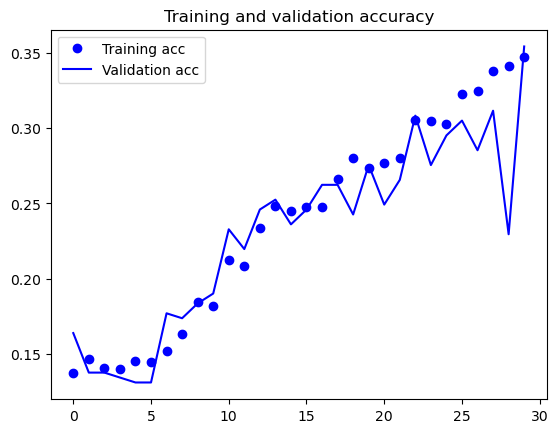

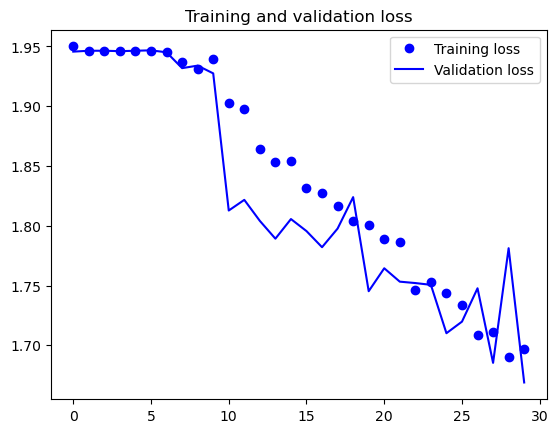

In [84]:
plot_evaluation(history_3)

 1/10 [==>...........................] - ETA: 2s

2023-09-11 15:22:31.028788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 32ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.2727    0.1224    0.1690        49
           1     0.3148    0.4359    0.3656        39
           2     0.1538    0.1765    0.1644        34
           3     0.4028    0.6744    0.5043        43
           4     0.4000    0.1961    0.2632        51
           5     0.1731    0.2571    0.2069        35
           6     0.6667    0.5091    0.5773        55

    accuracy                         0.3431       306
   macro avg     0.3406    0.3388    0.3215       306
weighted avg     0.3638    0.3431    0.3341       306



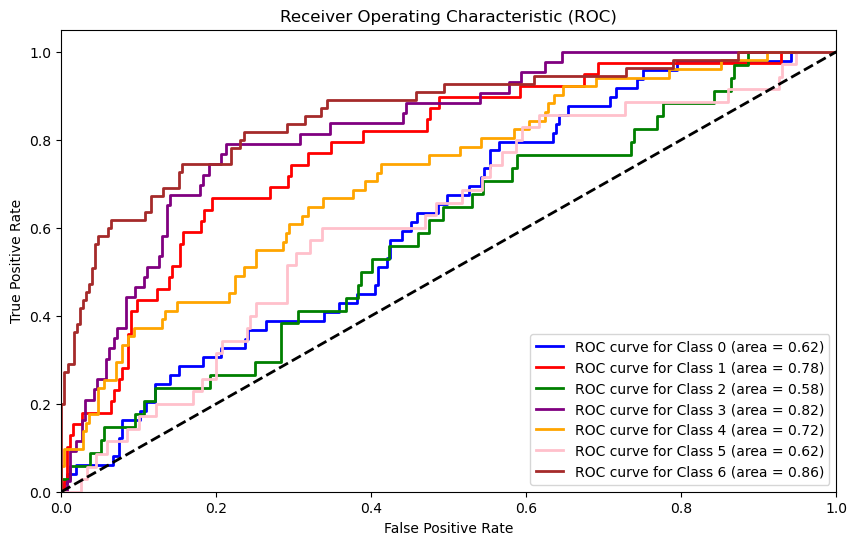

In [85]:
evaluate_model(model_3, X_test, y_test)

### 4.4 L2 regularization

In [136]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)  
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)  # Add dropout layer with rate 0.2
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)  # Add dropout layer with rate 0.2
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)  # Add dropout layer with rate 0.2
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)  # Add dropout layer with rate 0.2
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)  # Add dropout layer with rate 0.5

# Add L2 regularization to the dense layer
x = layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
outputs = layers.Dense(7, activation="softmax")(x)

model_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [140]:
model_4.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [141]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 dropout (Dropout)           (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                           

In [142]:
history_4 = model_4.fit(train_dataset, 
                        epochs=30, 
                        batch_size=BATCH_SIZE,
                        validation_data = validation_dataset, # evaluate the generalization capability of our model
                        shuffle = True,
                        verbose=1)

Epoch 1/30


2023-09-12 13:34:42.566282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-12 13:34:42.947983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 2:06 - loss: 11.8238 - accuracy: 0.1797

2023-09-12 13:34:49.254007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 23s - loss: 12.6101 - accuracy: 0.1602 

2023-09-12 13:34:49.910422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 15s - loss: 12.0558 - accuracy: 0.1380

2023-09-12 13:34:50.499895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 11.4236 - accuracy: 0.1387

2023-09-12 13:34:51.141500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 11s - loss: 10.8824 - accuracy: 0.1359

2023-09-12 13:34:51.762716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 10s - loss: 10.4180 - accuracy: 0.1432

2023-09-12 13:34:52.365759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 9s - loss: 10.0078 - accuracy: 0.1373 

2023-09-12 13:34:52.968037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 8s - loss: 9.6363 - accuracy: 0.1396 

2023-09-12 13:34:53.586311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 7s - loss: 9.2957 - accuracy: 0.1398

2023-09-12 13:34:54.187144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 6s - loss: 8.9843 - accuracy: 0.1367

2023-09-12 13:34:54.784681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 8.6940 - accuracy: 0.1364

2023-09-12 13:34:55.367366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 5s - loss: 8.4240 - accuracy: 0.1387

2023-09-12 13:34:55.940521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 4s - loss: 8.1721 - accuracy: 0.1382

2023-09-12 13:34:56.516556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 3s - loss: 7.9384 - accuracy: 0.1339

2023-09-12 13:34:57.059030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 7.7201 - accuracy: 0.1375

2023-09-12 13:34:57.597910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 7.5163 - accuracy: 0.1431

2023-09-12 13:34:58.164833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 7.3284 - accuracy: 0.1420

2023-09-12 13:34:58.704301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 7.1517 - accuracy: 0.1428

2023-09-12 13:34:59.236631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/20 [===========================>..] - ETA: 0s - loss: 6.9870 - accuracy: 0.1423

2023-09-12 13:34:59.753186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 6.9758 - accuracy: 0.1422

2023-09-12 13:35:00.434607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 19s 642ms/step - loss: 6.9758 - accuracy: 0.1422 - val_loss: 3.7995 - val_accuracy: 0.1180
Epoch 2/30


2023-09-12 13:35:00.799038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 12s - loss: 3.8028 - accuracy: 0.1172

2023-09-12 13:35:01.476630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 10s - loss: 3.7587 - accuracy: 0.1367

2023-09-12 13:35:02.037438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 9s - loss: 3.7153 - accuracy: 0.1667 

2023-09-12 13:35:02.603053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 8s - loss: 3.6775 - accuracy: 0.1680

2023-09-12 13:35:03.166142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 8s - loss: 3.6422 - accuracy: 0.1594

2023-09-12 13:35:03.734125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 7s - loss: 3.6091 - accuracy: 0.1576

2023-09-12 13:35:04.270117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 7s - loss: 3.5788 - accuracy: 0.1507

2023-09-12 13:35:04.822658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 6s - loss: 3.5490 - accuracy: 0.1494

2023-09-12 13:35:05.368575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 6s - loss: 3.5203 - accuracy: 0.1528

2023-09-12 13:35:05.897767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 5s - loss: 3.4929 - accuracy: 0.1500

2023-09-12 13:35:06.441712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 4s - loss: 3.4666 - accuracy: 0.1477

2023-09-12 13:35:07.030353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 4s - loss: 3.4410 - accuracy: 0.1504

2023-09-12 13:35:07.583068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 3s - loss: 3.4163 - accuracy: 0.1496

2023-09-12 13:35:08.145546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 3s - loss: 3.3923 - accuracy: 0.1507

2023-09-12 13:35:08.697002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 3.3682 - accuracy: 0.1526

2023-09-12 13:35:09.251514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 3.3449 - accuracy: 0.1548

2023-09-12 13:35:09.794278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 3.3224 - accuracy: 0.1558

2023-09-12 13:35:10.321253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 3.3003 - accuracy: 0.1558

2023-09-12 13:35:10.849233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/20 [===========================>..] - ETA: 0s - loss: 3.2785 - accuracy: 0.1575

2023-09-12 13:35:11.382019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 11s 570ms/step - loss: 3.2769 - accuracy: 0.1577 - val_loss: 2.8164 - val_accuracy: 0.1180
Epoch 3/30


2023-09-12 13:35:12.291797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 11s - loss: 2.8159 - accuracy: 0.1172

2023-09-12 13:35:12.920464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 9s - loss: 2.8007 - accuracy: 0.1133 

2023-09-12 13:35:13.467905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 9s - loss: 2.7845 - accuracy: 0.1302

2023-09-12 13:35:14.004955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 8s - loss: 2.7688 - accuracy: 0.1367

2023-09-12 13:35:14.565420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 8s - loss: 2.7538 - accuracy: 0.1391

2023-09-12 13:35:15.119356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 7s - loss: 2.7392 - accuracy: 0.1419

2023-09-12 13:35:15.665459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 7s - loss: 2.7248 - accuracy: 0.1429

2023-09-12 13:35:16.210341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 6s - loss: 2.7113 - accuracy: 0.1406

2023-09-12 13:35:16.770071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 6s - loss: 2.6981 - accuracy: 0.1415

2023-09-12 13:35:17.310176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 5s - loss: 2.6851 - accuracy: 0.1414

2023-09-12 13:35:17.845474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 4s - loss: 2.6727 - accuracy: 0.1406

2023-09-12 13:35:18.384523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 4s - loss: 2.6605 - accuracy: 0.1458

2023-09-12 13:35:18.923392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 3s - loss: 2.6489 - accuracy: 0.1442

2023-09-12 13:35:19.443173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 3s - loss: 2.6374 - accuracy: 0.1479

2023-09-12 13:35:19.990594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 2.6267 - accuracy: 0.1443

2023-09-12 13:35:20.524408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 2.6160 - accuracy: 0.1479

2023-09-12 13:35:21.065113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 2.6058 - accuracy: 0.1443

2023-09-12 13:35:21.596376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 2.5958 - accuracy: 0.1445

2023-09-12 13:35:22.115731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 2.5854 - accuracy: 0.1430

2023-09-12 13:35:22.648197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 11s 540ms/step - loss: 2.5854 - accuracy: 0.1430 - val_loss: 2.3830 - val_accuracy: 0.1180
Epoch 4/30


2023-09-12 13:35:23.168086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 12s - loss: 2.3877 - accuracy: 0.1094

2023-09-12 13:35:23.867771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 10s - loss: 2.3796 - accuracy: 0.1133

2023-09-12 13:35:24.434280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 9s - loss: 2.3723 - accuracy: 0.1250 

2023-09-12 13:35:25.007219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 9s - loss: 2.3649 - accuracy: 0.1289

2023-09-12 13:35:25.549809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 8s - loss: 2.3587 - accuracy: 0.1297

2023-09-12 13:35:26.090176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 7s - loss: 2.3529 - accuracy: 0.1276

2023-09-12 13:35:26.642190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 7s - loss: 2.3472 - accuracy: 0.1250

2023-09-12 13:35:27.206375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 6s - loss: 2.3414 - accuracy: 0.1240

2023-09-12 13:35:27.780286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 6s - loss: 2.3354 - accuracy: 0.1311

2023-09-12 13:35:28.342844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 5s - loss: 2.3297 - accuracy: 0.1344

2023-09-12 13:35:28.903129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 5s - loss: 2.3241 - accuracy: 0.1371

2023-09-12 13:35:29.458474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 4s - loss: 2.3187 - accuracy: 0.1367

2023-09-12 13:35:30.003450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 3s - loss: 2.3135 - accuracy: 0.1328

2023-09-12 13:35:30.596833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 3s - loss: 2.3085 - accuracy: 0.1350

2023-09-12 13:35:31.159156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 2.3034 - accuracy: 0.1380

2023-09-12 13:35:31.705599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 2.2985 - accuracy: 0.1377

2023-09-12 13:35:32.245945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 2.2937 - accuracy: 0.1383

2023-09-12 13:35:32.772854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 2.2890 - accuracy: 0.1393

2023-09-12 13:35:33.297317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 2.2841 - accuracy: 0.1393

2023-09-12 13:35:33.845892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 11s 549ms/step - loss: 2.2841 - accuracy: 0.1393 - val_loss: 2.1886 - val_accuracy: 0.1180
Epoch 5/30


2023-09-12 13:35:34.284273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 14s - loss: 2.1864 - accuracy: 0.1953

2023-09-12 13:35:35.040161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 10s - loss: 2.1870 - accuracy: 0.1797

2023-09-12 13:35:35.612336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 9s - loss: 2.1833 - accuracy: 0.1719 

2023-09-12 13:35:36.177990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 9s - loss: 2.1805 - accuracy: 0.1582

2023-09-12 13:35:36.734602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 8s - loss: 2.1766 - accuracy: 0.1531

2023-09-12 13:35:37.306129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 7s - loss: 2.1730 - accuracy: 0.1497

2023-09-12 13:35:37.866926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 7s - loss: 2.1702 - accuracy: 0.1507

2023-09-12 13:35:38.448669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 6s - loss: 2.1667 - accuracy: 0.1514

2023-09-12 13:35:39.041139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 6s - loss: 2.1632 - accuracy: 0.1580

2023-09-12 13:35:39.619301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 5s - loss: 2.1608 - accuracy: 0.1586

2023-09-12 13:35:40.201985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 5s - loss: 2.1581 - accuracy: 0.1591

2023-09-12 13:35:40.770618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 4s - loss: 2.1554 - accuracy: 0.1543

2023-09-12 13:35:41.339652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 4s - loss: 2.1525 - accuracy: 0.1550

2023-09-12 13:35:41.895641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 3s - loss: 2.1499 - accuracy: 0.1551

2023-09-12 13:35:42.459735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 2.1474 - accuracy: 0.1547

2023-09-12 13:35:43.058481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 2.1448 - accuracy: 0.1538

2023-09-12 13:35:43.648552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 2.1424 - accuracy: 0.1512

2023-09-12 13:35:44.231418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 2.1399 - accuracy: 0.1523

2023-09-12 13:35:44.794215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 2.1374 - accuracy: 0.1503

2023-09-12 13:35:45.331508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 12s 570ms/step - loss: 2.1374 - accuracy: 0.1503 - val_loss: 2.0873 - val_accuracy: 0.1803
Epoch 6/30


2023-09-12 13:35:45.852377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 12s - loss: 2.0871 - accuracy: 0.1172

2023-09-12 13:35:46.509474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 9s - loss: 2.0860 - accuracy: 0.1172 

2023-09-12 13:35:47.055729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 9s - loss: 2.0841 - accuracy: 0.1354

2023-09-12 13:35:47.640485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 9s - loss: 2.0824 - accuracy: 0.1445

2023-09-12 13:35:48.202492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 8s - loss: 2.0803 - accuracy: 0.1437

2023-09-12 13:35:48.752309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 7s - loss: 2.0786 - accuracy: 0.1445

2023-09-12 13:35:49.322210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 7s - loss: 2.0780 - accuracy: 0.1395

2023-09-12 13:35:49.886690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 6s - loss: 2.0768 - accuracy: 0.1348

2023-09-12 13:35:50.439507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 6s - loss: 2.0751 - accuracy: 0.1337

2023-09-12 13:35:50.992145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 5s - loss: 2.0732 - accuracy: 0.1352

2023-09-12 13:35:51.517882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 4s - loss: 2.0715 - accuracy: 0.1357

2023-09-12 13:35:52.065223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 4s - loss: 2.0697 - accuracy: 0.1387

2023-09-12 13:35:52.592480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 3s - loss: 2.0682 - accuracy: 0.1394

2023-09-12 13:35:53.135207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 3s - loss: 2.0666 - accuracy: 0.1384

2023-09-12 13:35:53.673797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 2.0649 - accuracy: 0.1432

2023-09-12 13:35:54.206654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 2.0648 - accuracy: 0.1416

2023-09-12 13:35:54.723390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 2.0640 - accuracy: 0.1379

2023-09-12 13:35:55.269216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 2.0627 - accuracy: 0.1372

2023-09-12 13:35:55.794479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 2.0614 - accuracy: 0.1364

2023-09-12 13:35:56.319593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 11s 537ms/step - loss: 2.0614 - accuracy: 0.1364 - val_loss: 2.0333 - val_accuracy: 0.1803
Epoch 7/30


2023-09-12 13:35:56.710180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 12s - loss: 2.0341 - accuracy: 0.1406

2023-09-12 13:35:57.355251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 9s - loss: 2.0337 - accuracy: 0.1328 

2023-09-12 13:35:57.893616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 9s - loss: 2.0333 - accuracy: 0.1380

2023-09-12 13:35:58.427522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 8s - loss: 2.0318 - accuracy: 0.1348

2023-09-12 13:35:58.975004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 8s - loss: 2.0308 - accuracy: 0.1312

2023-09-12 13:35:59.538014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 7s - loss: 2.0308 - accuracy: 0.1237

2023-09-12 13:36:00.092051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 7s - loss: 2.0298 - accuracy: 0.1228

2023-09-12 13:36:00.629484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 6s - loss: 2.0286 - accuracy: 0.1318

2023-09-12 13:36:01.161072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 5s - loss: 2.0273 - accuracy: 0.1406

2023-09-12 13:36:01.705364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 5s - loss: 2.0264 - accuracy: 0.1406

2023-09-12 13:36:02.251952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 4s - loss: 2.0257 - accuracy: 0.1378

2023-09-12 13:36:02.787855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 4s - loss: 2.0246 - accuracy: 0.1393

2023-09-12 13:36:03.319142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 3s - loss: 2.0235 - accuracy: 0.1388

2023-09-12 13:36:03.853169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 3s - loss: 2.0224 - accuracy: 0.1378

2023-09-12 13:36:04.379771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 2.0215 - accuracy: 0.1385

2023-09-12 13:36:04.903915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 2.0206 - accuracy: 0.1387

2023-09-12 13:36:05.443316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 2.0197 - accuracy: 0.1383

2023-09-12 13:36:05.987785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 2.0191 - accuracy: 0.1363

2023-09-12 13:36:06.554197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 2.0183 - accuracy: 0.1360

2023-09-12 13:36:07.083438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 11s 536ms/step - loss: 2.0183 - accuracy: 0.1360 - val_loss: 1.9985 - val_accuracy: 0.1803
Epoch 8/30


2023-09-12 13:36:07.534432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 12s - loss: 2.0006 - accuracy: 0.1016

2023-09-12 13:36:08.185606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 9s - loss: 2.0002 - accuracy: 0.1211 

2023-09-12 13:36:08.731142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 9s - loss: 1.9990 - accuracy: 0.1250

2023-09-12 13:36:09.271158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 8s - loss: 1.9983 - accuracy: 0.1230

2023-09-12 13:36:09.822140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 8s - loss: 1.9977 - accuracy: 0.1266

2023-09-12 13:36:10.371636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 7s - loss: 1.9968 - accuracy: 0.1315

2023-09-12 13:36:10.918272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 7s - loss: 1.9960 - accuracy: 0.1295

2023-09-12 13:36:11.478910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 6s - loss: 1.9954 - accuracy: 0.1299

2023-09-12 13:36:12.035240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 6s - loss: 1.9945 - accuracy: 0.1337

2023-09-12 13:36:12.589940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 5s - loss: 1.9938 - accuracy: 0.1367

2023-09-12 13:36:13.141270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 4s - loss: 1.9932 - accuracy: 0.1385

2023-09-12 13:36:13.695221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 4s - loss: 1.9925 - accuracy: 0.1348

2023-09-12 13:36:14.254047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 3s - loss: 1.9918 - accuracy: 0.1388

2023-09-12 13:36:14.822332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 3s - loss: 1.9913 - accuracy: 0.1401

2023-09-12 13:36:15.386127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 2s - loss: 1.9906 - accuracy: 0.1437

2023-09-12 13:36:15.960224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 1.9902 - accuracy: 0.1421

2023-09-12 13:36:16.526638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9895 - accuracy: 0.1443

2023-09-12 13:36:17.109845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9888 - accuracy: 0.1441

2023-09-12 13:36:17.694502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9882 - accuracy: 0.1417

2023-09-12 13:36:18.279437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 11s 554ms/step - loss: 1.9882 - accuracy: 0.1417 - val_loss: 1.9767 - val_accuracy: 0.1803
Epoch 9/30


2023-09-12 13:36:18.713148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 13s - loss: 1.9766 - accuracy: 0.1406

2023-09-12 13:36:19.442898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 10s - loss: 1.9781 - accuracy: 0.1250

2023-09-12 13:36:20.040566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 10s - loss: 1.9778 - accuracy: 0.1276

2023-09-12 13:36:20.649993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 9s - loss: 1.9775 - accuracy: 0.1367 

2023-09-12 13:36:21.261117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 9s - loss: 1.9767 - accuracy: 0.1359

2023-09-12 13:36:21.864801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 8s - loss: 1.9758 - accuracy: 0.1354

2023-09-12 13:36:22.487492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 8s - loss: 1.9751 - accuracy: 0.1384

2023-09-12 13:36:23.167350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 7s - loss: 1.9747 - accuracy: 0.1406

2023-09-12 13:36:23.819339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 6s - loss: 1.9742 - accuracy: 0.1380

2023-09-12 13:36:24.462684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 6s - loss: 1.9736 - accuracy: 0.1437

2023-09-12 13:36:25.105787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 5s - loss: 1.9731 - accuracy: 0.1428

2023-09-12 13:36:25.727883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 5s - loss: 1.9726 - accuracy: 0.1426

2023-09-12 13:36:26.360238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 4s - loss: 1.9723 - accuracy: 0.1436

2023-09-12 13:36:27.009747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 3s - loss: 1.9719 - accuracy: 0.1440

2023-09-12 13:36:27.641909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.9717 - accuracy: 0.1411

2023-09-12 13:36:28.297117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 1.9714 - accuracy: 0.1406

2023-09-12 13:36:28.949704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 1s - loss: 1.9711 - accuracy: 0.1383

2023-09-12 13:36:29.604841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9708 - accuracy: 0.1380

2023-09-12 13:36:30.277724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9704 - accuracy: 0.1401

2023-09-12 13:36:30.940463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 13s 633ms/step - loss: 1.9704 - accuracy: 0.1401 - val_loss: 1.9645 - val_accuracy: 0.1213
Epoch 10/30


2023-09-12 13:36:31.469283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 15s - loss: 1.9627 - accuracy: 0.1797

2023-09-12 13:36:32.283167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 12s - loss: 1.9637 - accuracy: 0.1523

2023-09-12 13:36:32.953292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 11s - loss: 1.9642 - accuracy: 0.1615

2023-09-12 13:36:33.620943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 10s - loss: 1.9633 - accuracy: 0.1738

2023-09-12 13:36:34.298656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 10s - loss: 1.9631 - accuracy: 0.1688

2023-09-12 13:36:34.983777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 9s - loss: 1.9626 - accuracy: 0.1706 

2023-09-12 13:36:35.672183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 8s - loss: 1.9625 - accuracy: 0.1674

2023-09-12 13:36:36.348792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 8s - loss: 1.9623 - accuracy: 0.1602

2023-09-12 13:36:37.024155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 7s - loss: 1.9623 - accuracy: 0.1580

2023-09-12 13:36:37.723651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 6s - loss: 1.9618 - accuracy: 0.1609

2023-09-12 13:36:38.417181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 6s - loss: 1.9613 - accuracy: 0.1605

2023-09-12 13:36:39.116728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 5s - loss: 1.9611 - accuracy: 0.1608

2023-09-12 13:36:39.831546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 4s - loss: 1.9613 - accuracy: 0.1562

2023-09-12 13:36:40.570865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 4s - loss: 1.9615 - accuracy: 0.1540

2023-09-12 13:36:41.310974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 3s - loss: 1.9612 - accuracy: 0.1531

2023-09-12 13:36:42.071920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 2s - loss: 1.9611 - accuracy: 0.1514

2023-09-12 13:36:42.867324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9609 - accuracy: 0.1498

2023-09-12 13:36:43.637260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9608 - accuracy: 0.1497

2023-09-12 13:36:44.410269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9606 - accuracy: 0.1491

2023-09-12 13:36:45.178914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 14s 709ms/step - loss: 1.9606 - accuracy: 0.1491 - val_loss: 1.9576 - val_accuracy: 0.1377
Epoch 11/30


2023-09-12 13:36:45.744019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 16s - loss: 1.9553 - accuracy: 0.1719

2023-09-12 13:36:46.615859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 13s - loss: 1.9547 - accuracy: 0.1484

2023-09-12 13:36:47.345495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 12s - loss: 1.9557 - accuracy: 0.1380

2023-09-12 13:36:48.099260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 12s - loss: 1.9551 - accuracy: 0.1426

2023-09-12 13:36:48.930260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 11s - loss: 1.9537 - accuracy: 0.1469

2023-09-12 13:36:49.757576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 11s - loss: 1.9551 - accuracy: 0.1432

2023-09-12 13:36:50.616429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 10s - loss: 1.9544 - accuracy: 0.1507

2023-09-12 13:36:51.493096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 9s - loss: 1.9561 - accuracy: 0.1514 

2023-09-12 13:36:52.392645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9565 - accuracy: 0.1554

2023-09-12 13:36:53.338350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.9565 - accuracy: 0.1555

2023-09-12 13:36:54.272935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.9562 - accuracy: 0.1605

2023-09-12 13:36:55.203416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.9562 - accuracy: 0.1569

2023-09-12 13:36:56.120091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9559 - accuracy: 0.1605

2023-09-12 13:36:57.033882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9558 - accuracy: 0.1568

2023-09-12 13:36:57.928110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9556 - accuracy: 0.1557

2023-09-12 13:36:58.823952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9553 - accuracy: 0.1587

2023-09-12 13:36:59.730123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9553 - accuracy: 0.1549

2023-09-12 13:37:00.644868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9552 - accuracy: 0.1549

2023-09-12 13:37:01.586468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9551 - accuracy: 0.1528

2023-09-12 13:37:02.558613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 17s 874ms/step - loss: 1.9551 - accuracy: 0.1528 - val_loss: 1.9544 - val_accuracy: 0.1213
Epoch 12/30


2023-09-12 13:37:03.202547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 18s - loss: 1.9541 - accuracy: 0.1328

2023-09-12 13:37:04.204537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 16s - loss: 1.9548 - accuracy: 0.1094

2023-09-12 13:37:05.121721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 15s - loss: 1.9529 - accuracy: 0.1224

2023-09-12 13:37:06.058048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 15s - loss: 1.9531 - accuracy: 0.1270

2023-09-12 13:37:07.022381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 14s - loss: 1.9532 - accuracy: 0.1297

2023-09-12 13:37:08.018829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 13s - loss: 1.9531 - accuracy: 0.1341

2023-09-12 13:37:09.061457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 12s - loss: 1.9528 - accuracy: 0.1440

2023-09-12 13:37:10.116563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 11s - loss: 1.9524 - accuracy: 0.1455

2023-09-12 13:37:11.152330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 10s - loss: 1.9521 - accuracy: 0.1493

2023-09-12 13:37:12.162678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 9s - loss: 1.9522 - accuracy: 0.1469 

2023-09-12 13:37:13.160965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 8s - loss: 1.9522 - accuracy: 0.1442

2023-09-12 13:37:14.155599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9523 - accuracy: 0.1439

2023-09-12 13:37:15.169629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9522 - accuracy: 0.1418

2023-09-12 13:37:16.154344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9521 - accuracy: 0.1440

2023-09-12 13:37:17.131472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9521 - accuracy: 0.1411

2023-09-12 13:37:18.071477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9520 - accuracy: 0.1411

2023-09-12 13:37:19.033202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9520 - accuracy: 0.1383

2023-09-12 13:37:19.993795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9520 - accuracy: 0.1363

2023-09-12 13:37:20.928375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9518 - accuracy: 0.1376

2023-09-12 13:37:21.880789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 19s 965ms/step - loss: 1.9518 - accuracy: 0.1376 - val_loss: 1.9513 - val_accuracy: 0.1377
Epoch 13/30


2023-09-12 13:37:22.532326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 23s - loss: 1.9527 - accuracy: 0.1406

2023-09-12 13:37:23.767041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 15s - loss: 1.9517 - accuracy: 0.1445

2023-09-12 13:37:24.652353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 15s - loss: 1.9519 - accuracy: 0.1276

2023-09-12 13:37:25.575974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 14s - loss: 1.9513 - accuracy: 0.1387

2023-09-12 13:37:26.551839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 14s - loss: 1.9506 - accuracy: 0.1359

2023-09-12 13:37:27.539193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 13s - loss: 1.9506 - accuracy: 0.1484

2023-09-12 13:37:28.547137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 12s - loss: 1.9504 - accuracy: 0.1440

2023-09-12 13:37:29.557261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 11s - loss: 1.9503 - accuracy: 0.1436

2023-09-12 13:37:30.566659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 10s - loss: 1.9503 - accuracy: 0.1441

2023-09-12 13:37:31.531198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 9s - loss: 1.9502 - accuracy: 0.1445 

2023-09-12 13:37:32.480642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 8s - loss: 1.9502 - accuracy: 0.1449

2023-09-12 13:37:33.459725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9501 - accuracy: 0.1419

2023-09-12 13:37:34.447696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9502 - accuracy: 0.1406

2023-09-12 13:37:35.433547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9500 - accuracy: 0.1434

2023-09-12 13:37:36.414719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9498 - accuracy: 0.1401

2023-09-12 13:37:37.406665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9497 - accuracy: 0.1406

2023-09-12 13:37:38.393041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9496 - accuracy: 0.1420

2023-09-12 13:37:39.384754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9494 - accuracy: 0.1398

2023-09-12 13:37:40.347877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9494 - accuracy: 0.1417

2023-09-12 13:37:41.302886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 19s 959ms/step - loss: 1.9494 - accuracy: 0.1417 - val_loss: 1.9499 - val_accuracy: 0.1180
Epoch 14/30


2023-09-12 13:37:41.976024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 19s - loss: 1.9503 - accuracy: 0.1484

2023-09-12 13:37:43.001750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 15s - loss: 1.9493 - accuracy: 0.1367

2023-09-12 13:37:43.858773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 14s - loss: 1.9494 - accuracy: 0.1380

2023-09-12 13:37:44.729732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 14s - loss: 1.9490 - accuracy: 0.1484

2023-09-12 13:37:45.628587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 13s - loss: 1.9490 - accuracy: 0.1500

2023-09-12 13:37:46.554372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 12s - loss: 1.9486 - accuracy: 0.1523

2023-09-12 13:37:47.476108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 11s - loss: 1.9485 - accuracy: 0.1440

2023-09-12 13:37:48.411813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9485 - accuracy: 0.1406

2023-09-12 13:37:49.356239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 10s - loss: 1.9482 - accuracy: 0.1424

2023-09-12 13:37:50.280190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 9s - loss: 1.9482 - accuracy: 0.1453 

2023-09-12 13:37:51.192251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 8s - loss: 1.9482 - accuracy: 0.1428

2023-09-12 13:37:52.092555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9481 - accuracy: 0.1445

2023-09-12 13:37:53.060204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9482 - accuracy: 0.1418

2023-09-12 13:37:54.014261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9482 - accuracy: 0.1406

2023-09-12 13:37:54.952929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9481 - accuracy: 0.1448

2023-09-12 13:37:55.930123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9480 - accuracy: 0.1460

2023-09-12 13:37:56.839935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9479 - accuracy: 0.1452

2023-09-12 13:37:57.715596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9479 - accuracy: 0.1432

2023-09-12 13:37:58.587239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9479 - accuracy: 0.1438

2023-09-12 13:37:59.437402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 18s 900ms/step - loss: 1.9479 - accuracy: 0.1438 - val_loss: 1.9489 - val_accuracy: 0.1180
Epoch 15/30


2023-09-12 13:38:00.091135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 17s - loss: 1.9479 - accuracy: 0.1328

2023-09-12 13:38:01.016594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 15s - loss: 1.9480 - accuracy: 0.1250

2023-09-12 13:38:01.866588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 14s - loss: 1.9477 - accuracy: 0.1250

2023-09-12 13:38:02.753948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 14s - loss: 1.9477 - accuracy: 0.1328

2023-09-12 13:38:03.723313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 14s - loss: 1.9478 - accuracy: 0.1328

2023-09-12 13:38:04.802400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 13s - loss: 1.9479 - accuracy: 0.1341

2023-09-12 13:38:05.909232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 12s - loss: 1.9477 - accuracy: 0.1406

2023-09-12 13:38:06.975212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 11s - loss: 1.9477 - accuracy: 0.1367

2023-09-12 13:38:07.926662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 10s - loss: 1.9477 - accuracy: 0.1380

2023-09-12 13:38:08.790216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 9s - loss: 1.9474 - accuracy: 0.1391 

2023-09-12 13:38:09.659159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 8s - loss: 1.9476 - accuracy: 0.1392

2023-09-12 13:38:10.527642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9474 - accuracy: 0.1406

2023-09-12 13:38:11.415902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9472 - accuracy: 0.1466

2023-09-12 13:38:12.328813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9471 - accuracy: 0.1462

2023-09-12 13:38:13.257104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9472 - accuracy: 0.1458

2023-09-12 13:38:14.171488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9471 - accuracy: 0.1519

2023-09-12 13:38:15.076216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9470 - accuracy: 0.1512

2023-09-12 13:38:15.952631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9469 - accuracy: 0.1523

2023-09-12 13:38:16.827422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9468 - accuracy: 0.1544

2023-09-12 13:38:17.722485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 18s 913ms/step - loss: 1.9468 - accuracy: 0.1544 - val_loss: 1.9486 - val_accuracy: 0.1213
Epoch 16/30


2023-09-12 13:38:18.354185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 17s - loss: 1.9586 - accuracy: 0.1406

2023-09-12 13:38:19.268610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 15s - loss: 1.9525 - accuracy: 0.1484

2023-09-12 13:38:20.116759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 14s - loss: 1.9527 - accuracy: 0.1432

2023-09-12 13:38:21.010642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 14s - loss: 1.9512 - accuracy: 0.1445

2023-09-12 13:38:21.941188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 13s - loss: 1.9504 - accuracy: 0.1641

2023-09-12 13:38:22.874352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 12s - loss: 1.9502 - accuracy: 0.1562

2023-09-12 13:38:23.848795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 11s - loss: 1.9499 - accuracy: 0.1562

2023-09-12 13:38:24.816450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 11s - loss: 1.9497 - accuracy: 0.1553

2023-09-12 13:38:25.757436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 10s - loss: 1.9495 - accuracy: 0.1545

2023-09-12 13:38:26.680097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 9s - loss: 1.9492 - accuracy: 0.1516 

2023-09-12 13:38:27.567825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 8s - loss: 1.9490 - accuracy: 0.1541

2023-09-12 13:38:28.468483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9490 - accuracy: 0.1523

2023-09-12 13:38:29.352612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9489 - accuracy: 0.1478

2023-09-12 13:38:30.225677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9487 - accuracy: 0.1462

2023-09-12 13:38:31.116661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9486 - accuracy: 0.1464

2023-09-12 13:38:32.026641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9479 - accuracy: 0.1475

2023-09-12 13:38:33.001411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9477 - accuracy: 0.1484

2023-09-12 13:38:33.933176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9476 - accuracy: 0.1467

2023-09-12 13:38:34.839132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/20 [===========================>..] - ETA: 0s - loss: 1.9475 - accuracy: 0.1476

2023-09-12 13:38:35.794222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 18s 911ms/step - loss: 1.9476 - accuracy: 0.1471 - val_loss: 1.9466 - val_accuracy: 0.1344
Epoch 17/30


2023-09-12 13:38:36.564765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 21s - loss: 1.9434 - accuracy: 0.1641

2023-09-12 13:38:37.700473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 14s - loss: 1.9500 - accuracy: 0.1680

2023-09-12 13:38:38.536702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 13s - loss: 1.9478 - accuracy: 0.1745

2023-09-12 13:38:39.343391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 1.9480 - accuracy: 0.1680

2023-09-12 13:38:40.158735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 12s - loss: 1.9481 - accuracy: 0.1672

2023-09-12 13:38:40.978278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 11s - loss: 1.9480 - accuracy: 0.1549

2023-09-12 13:38:41.845250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 10s - loss: 1.9483 - accuracy: 0.1562

2023-09-12 13:38:42.721384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9484 - accuracy: 0.1523

2023-09-12 13:38:43.602422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9482 - accuracy: 0.1589 

2023-09-12 13:38:44.494801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.9481 - accuracy: 0.1633

2023-09-12 13:38:45.363873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.9482 - accuracy: 0.1605

2023-09-12 13:38:46.224630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.9482 - accuracy: 0.1589

2023-09-12 13:38:47.088756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.9484 - accuracy: 0.1562

2023-09-12 13:38:47.940868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9487 - accuracy: 0.1562

2023-09-12 13:38:48.784279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9487 - accuracy: 0.1557

2023-09-12 13:38:49.638734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9483 - accuracy: 0.1553

2023-09-12 13:38:50.494533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9482 - accuracy: 0.1567

2023-09-12 13:38:51.357602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9484 - accuracy: 0.1567

2023-09-12 13:38:52.233554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9485 - accuracy: 0.1557

2023-09-12 13:38:53.141596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 17s 850ms/step - loss: 1.9485 - accuracy: 0.1557 - val_loss: 1.9498 - val_accuracy: 0.1377
Epoch 18/30


2023-09-12 13:38:53.846624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 22s - loss: 1.9427 - accuracy: 0.1250

2023-09-12 13:38:55.036053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 14s - loss: 1.9471 - accuracy: 0.1094

2023-09-12 13:38:55.865258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 14s - loss: 1.9453 - accuracy: 0.1328

2023-09-12 13:38:56.713617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 1.9465 - accuracy: 0.1348

2023-09-12 13:38:57.533100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 12s - loss: 1.9481 - accuracy: 0.1359

2023-09-12 13:38:58.372915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 11s - loss: 1.9474 - accuracy: 0.1419

2023-09-12 13:38:59.216199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 10s - loss: 1.9455 - accuracy: 0.1540

2023-09-12 13:39:00.106959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9444 - accuracy: 0.1465

2023-09-12 13:39:01.015636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9435 - accuracy: 0.1519 

2023-09-12 13:39:01.914784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.9442 - accuracy: 0.1508

2023-09-12 13:39:02.841168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.9440 - accuracy: 0.1520

2023-09-12 13:39:03.740885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.9438 - accuracy: 0.1530

2023-09-12 13:39:04.624774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9452 - accuracy: 0.1508

2023-09-12 13:39:05.513325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9451 - accuracy: 0.1512

2023-09-12 13:39:06.400387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9470 - accuracy: 0.1490

2023-09-12 13:39:07.269902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9503 - accuracy: 0.1465

2023-09-12 13:39:08.131803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9504 - accuracy: 0.1461

2023-09-12 13:39:08.990646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9508 - accuracy: 0.1467

2023-09-12 13:39:09.829759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9503 - accuracy: 0.1487

2023-09-12 13:39:10.640794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 17s 852ms/step - loss: 1.9503 - accuracy: 0.1487 - val_loss: 1.9554 - val_accuracy: 0.1410
Epoch 19/30


2023-09-12 13:39:11.217729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 16s - loss: 1.9578 - accuracy: 0.1641

2023-09-12 13:39:12.085831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 13s - loss: 1.9542 - accuracy: 0.1445

2023-09-12 13:39:12.858719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 13s - loss: 1.9520 - accuracy: 0.1589

2023-09-12 13:39:13.657360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 12s - loss: 1.9516 - accuracy: 0.1641

2023-09-12 13:39:14.490723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 12s - loss: 1.9518 - accuracy: 0.1703

2023-09-12 13:39:15.343215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 11s - loss: 1.9512 - accuracy: 0.1758

2023-09-12 13:39:16.207821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 10s - loss: 1.9521 - accuracy: 0.1652

2023-09-12 13:39:17.111184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9515 - accuracy: 0.1719

2023-09-12 13:39:17.992439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9517 - accuracy: 0.1641 

2023-09-12 13:39:18.878922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.9514 - accuracy: 0.1672

2023-09-12 13:39:19.737740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.9517 - accuracy: 0.1641

2023-09-12 13:39:20.585903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.9504 - accuracy: 0.1641

2023-09-12 13:39:21.409261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 5s - loss: 1.9504 - accuracy: 0.1635

2023-09-12 13:39:22.225491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9502 - accuracy: 0.1624

2023-09-12 13:39:23.040470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9503 - accuracy: 0.1615

2023-09-12 13:39:23.889415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9500 - accuracy: 0.1567

2023-09-12 13:39:24.745911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9492 - accuracy: 0.1581

2023-09-12 13:39:25.631195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9493 - accuracy: 0.1606

2023-09-12 13:39:26.539251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9505 - accuracy: 0.1598

2023-09-12 13:39:27.433498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 17s 843ms/step - loss: 1.9505 - accuracy: 0.1598 - val_loss: 1.9505 - val_accuracy: 0.1443
Epoch 20/30


2023-09-12 13:39:28.099945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 17s - loss: 1.9456 - accuracy: 0.1484

2023-09-12 13:39:29.059224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 14s - loss: 1.9451 - accuracy: 0.1602

2023-09-12 13:39:29.888090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 14s - loss: 1.9456 - accuracy: 0.1536

2023-09-12 13:39:30.724402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 1.9476 - accuracy: 0.1582

2023-09-12 13:39:31.546639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 12s - loss: 1.9479 - accuracy: 0.1609

2023-09-12 13:39:32.371296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 11s - loss: 1.9482 - accuracy: 0.1602

2023-09-12 13:39:33.216837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 10s - loss: 1.9494 - accuracy: 0.1618

2023-09-12 13:39:34.081009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9496 - accuracy: 0.1602

2023-09-12 13:39:34.941959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9509 - accuracy: 0.1502 

2023-09-12 13:39:35.814690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.9514 - accuracy: 0.1508

2023-09-12 13:39:36.714831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.9514 - accuracy: 0.1499

2023-09-12 13:39:37.609505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.9515 - accuracy: 0.1478

2023-09-12 13:39:38.501672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9521 - accuracy: 0.1466

2023-09-12 13:39:39.369083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9520 - accuracy: 0.1484

2023-09-12 13:39:40.237128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9518 - accuracy: 0.1495

2023-09-12 13:39:41.101588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9518 - accuracy: 0.1509

2023-09-12 13:39:41.941336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9517 - accuracy: 0.1503

2023-09-12 13:39:42.801771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9515 - accuracy: 0.1497

2023-09-12 13:39:43.657520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9516 - accuracy: 0.1483

2023-09-12 13:39:44.507944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 17s 846ms/step - loss: 1.9516 - accuracy: 0.1483 - val_loss: 1.9518 - val_accuracy: 0.1311
Epoch 21/30


2023-09-12 13:39:45.127479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 16s - loss: 1.9494 - accuracy: 0.1641

2023-09-12 13:39:46.001936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 14s - loss: 1.9473 - accuracy: 0.1680

2023-09-12 13:39:46.795242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 13s - loss: 1.9469 - accuracy: 0.1693

2023-09-12 13:39:47.619088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 1.9470 - accuracy: 0.1738

2023-09-12 13:39:48.465353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 12s - loss: 1.9469 - accuracy: 0.1719

2023-09-12 13:39:49.330595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 11s - loss: 1.9475 - accuracy: 0.1641

2023-09-12 13:39:50.223509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 11s - loss: 1.9477 - accuracy: 0.1641

2023-09-12 13:39:51.131581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9479 - accuracy: 0.1611

2023-09-12 13:39:52.034228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9481 - accuracy: 0.1615 

2023-09-12 13:39:52.926164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.9482 - accuracy: 0.1625

2023-09-12 13:39:53.819171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.9477 - accuracy: 0.1612

2023-09-12 13:39:54.682567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.9476 - accuracy: 0.1582

2023-09-12 13:39:55.540551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9467 - accuracy: 0.1593

2023-09-12 13:39:56.396047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9454 - accuracy: 0.1613

2023-09-12 13:39:57.246359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9444 - accuracy: 0.1604

2023-09-12 13:39:58.091571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9447 - accuracy: 0.1587

2023-09-12 13:39:58.940117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9456 - accuracy: 0.1576

2023-09-12 13:39:59.787502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9456 - accuracy: 0.1589

2023-09-12 13:40:00.619577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9459 - accuracy: 0.1598

2023-09-12 13:40:01.458259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 17s 847ms/step - loss: 1.9459 - accuracy: 0.1598 - val_loss: 1.9457 - val_accuracy: 0.1344
Epoch 22/30


2023-09-12 13:40:02.091261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 17s - loss: 1.9403 - accuracy: 0.1328

2023-09-12 13:40:03.026919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 14s - loss: 1.9390 - accuracy: 0.1445

2023-09-12 13:40:03.840566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 14s - loss: 1.9409 - accuracy: 0.1615

2023-09-12 13:40:04.711775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 1.9402 - accuracy: 0.1484

2023-09-12 13:40:05.603040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 13s - loss: 1.9446 - accuracy: 0.1391

2023-09-12 13:40:06.501819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 12s - loss: 1.9446 - accuracy: 0.1497

2023-09-12 13:40:07.432742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 11s - loss: 1.9461 - accuracy: 0.1496

2023-09-12 13:40:08.332694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9459 - accuracy: 0.1553

2023-09-12 13:40:09.224668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9451 - accuracy: 0.1554 

2023-09-12 13:40:10.087861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.9464 - accuracy: 0.1516

2023-09-12 13:40:10.941538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.9467 - accuracy: 0.1499

2023-09-12 13:40:11.799072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9462 - accuracy: 0.1536

2023-09-12 13:40:12.662776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9456 - accuracy: 0.1544

2023-09-12 13:40:13.522640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9450 - accuracy: 0.1540

2023-09-12 13:40:14.396355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9445 - accuracy: 0.1562

2023-09-12 13:40:15.285261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9450 - accuracy: 0.1558

2023-09-12 13:40:16.187071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9447 - accuracy: 0.1576

2023-09-12 13:40:17.067395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9445 - accuracy: 0.1571

2023-09-12 13:40:17.955555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9428 - accuracy: 0.1573

2023-09-12 13:40:18.829714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 17s 867ms/step - loss: 1.9428 - accuracy: 0.1573 - val_loss: 1.9658 - val_accuracy: 0.1836
Epoch 23/30


2023-09-12 13:40:19.492630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 16s - loss: 2.1471 - accuracy: 0.1016

2023-09-12 13:40:20.405042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 14s - loss: 2.0432 - accuracy: 0.1250

2023-09-12 13:40:21.193729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 13s - loss: 2.0068 - accuracy: 0.1328

2023-09-12 13:40:22.009520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 1.9911 - accuracy: 0.1328

2023-09-12 13:40:22.865331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 12s - loss: 1.9817 - accuracy: 0.1500

2023-09-12 13:40:23.749212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 11s - loss: 1.9759 - accuracy: 0.1562

2023-09-12 13:40:24.638967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 11s - loss: 1.9716 - accuracy: 0.1507

2023-09-12 13:40:25.549716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9685 - accuracy: 0.1494

2023-09-12 13:40:26.468790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9662 - accuracy: 0.1484 

2023-09-12 13:40:27.379288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.9650 - accuracy: 0.1469

2023-09-12 13:40:28.268578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.9640 - accuracy: 0.1435

2023-09-12 13:40:29.141574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.9630 - accuracy: 0.1439

2023-09-12 13:40:30.006646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9618 - accuracy: 0.1424

2023-09-12 13:40:30.878629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9612 - accuracy: 0.1440

2023-09-12 13:40:31.722814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9607 - accuracy: 0.1432

2023-09-12 13:40:32.576410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9600 - accuracy: 0.1426

2023-09-12 13:40:33.415191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9598 - accuracy: 0.1434

2023-09-12 13:40:34.249088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9593 - accuracy: 0.1406

2023-09-12 13:40:35.069682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9589 - accuracy: 0.1397

2023-09-12 13:40:35.894573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 17s 846ms/step - loss: 1.9589 - accuracy: 0.1397 - val_loss: 1.9530 - val_accuracy: 0.1344
Epoch 24/30


2023-09-12 13:40:36.456370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 16s - loss: 1.9501 - accuracy: 0.1250

2023-09-12 13:40:37.325102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 14s - loss: 1.9496 - accuracy: 0.1289

2023-09-12 13:40:38.132102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 13s - loss: 1.9480 - accuracy: 0.1458

2023-09-12 13:40:38.966873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 1.9490 - accuracy: 0.1543

2023-09-12 13:40:39.831226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 12s - loss: 1.9486 - accuracy: 0.1578

2023-09-12 13:40:40.734424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 12s - loss: 1.9496 - accuracy: 0.1589

2023-09-12 13:40:41.649959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 11s - loss: 1.9500 - accuracy: 0.1529

2023-09-12 13:40:42.561612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9501 - accuracy: 0.1494

2023-09-12 13:40:43.461822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9500 - accuracy: 0.1545 

2023-09-12 13:40:44.322424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.9501 - accuracy: 0.1508

2023-09-12 13:40:45.179171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.9497 - accuracy: 0.1520

2023-09-12 13:40:46.020426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 6s - loss: 1.9503 - accuracy: 0.1517

2023-09-12 13:40:46.852640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9504 - accuracy: 0.1490

2023-09-12 13:40:47.691165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9502 - accuracy: 0.1490

2023-09-12 13:40:48.527725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9501 - accuracy: 0.1484

2023-09-12 13:40:49.395518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9502 - accuracy: 0.1460

2023-09-12 13:40:50.277393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9501 - accuracy: 0.1466

2023-09-12 13:40:51.203712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9500 - accuracy: 0.1454

2023-09-12 13:40:52.119748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9498 - accuracy: 0.1475

2023-09-12 13:40:53.027008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 17s 858ms/step - loss: 1.9498 - accuracy: 0.1475 - val_loss: 1.9512 - val_accuracy: 0.1377
Epoch 25/30


2023-09-12 13:40:53.631030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 16s - loss: 1.9506 - accuracy: 0.1250

2023-09-12 13:40:54.517280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 14s - loss: 1.9480 - accuracy: 0.1367

2023-09-12 13:40:55.322463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 13s - loss: 1.9485 - accuracy: 0.1432

2023-09-12 13:40:56.151436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 1.9486 - accuracy: 0.1465

2023-09-12 13:40:56.977183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 12s - loss: 1.9485 - accuracy: 0.1484

2023-09-12 13:40:57.810310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 11s - loss: 1.9488 - accuracy: 0.1458

2023-09-12 13:40:58.672010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 10s - loss: 1.9489 - accuracy: 0.1451

2023-09-12 13:40:59.548975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9485 - accuracy: 0.1475

2023-09-12 13:41:00.462242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9482 - accuracy: 0.1476 

2023-09-12 13:41:01.408416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.9488 - accuracy: 0.1461

2023-09-12 13:41:02.352567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.9482 - accuracy: 0.1449

2023-09-12 13:41:03.288473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9483 - accuracy: 0.1432

2023-09-12 13:41:04.233165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9478 - accuracy: 0.1460

2023-09-12 13:41:05.196250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9473 - accuracy: 0.1484

2023-09-12 13:41:06.145347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9479 - accuracy: 0.1453

2023-09-12 13:41:07.065724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9479 - accuracy: 0.1460

2023-09-12 13:41:07.941983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9481 - accuracy: 0.1452

2023-09-12 13:41:08.802944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9482 - accuracy: 0.1489

2023-09-12 13:41:09.684942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9481 - accuracy: 0.1487

2023-09-12 13:41:10.589730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 18s 878ms/step - loss: 1.9481 - accuracy: 0.1487 - val_loss: 1.9507 - val_accuracy: 0.1377
Epoch 26/30


2023-09-12 13:41:11.197956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 19s - loss: 1.9456 - accuracy: 0.1484

2023-09-12 13:41:12.251970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 16s - loss: 1.9477 - accuracy: 0.1328

2023-09-12 13:41:13.151104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 15s - loss: 1.9481 - accuracy: 0.1276

2023-09-12 13:41:14.074046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 14s - loss: 1.9484 - accuracy: 0.1328

2023-09-12 13:41:15.069633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 14s - loss: 1.9480 - accuracy: 0.1375

2023-09-12 13:41:16.077232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 13s - loss: 1.9473 - accuracy: 0.1393

2023-09-12 13:41:17.047642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 12s - loss: 1.9474 - accuracy: 0.1417

2023-09-12 13:41:18.084085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 11s - loss: 1.9475 - accuracy: 0.1465

2023-09-12 13:41:19.065351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 10s - loss: 1.9481 - accuracy: 0.1415

2023-09-12 13:41:20.014066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 9s - loss: 1.9474 - accuracy: 0.1437 

2023-09-12 13:41:20.916237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 8s - loss: 1.9472 - accuracy: 0.1399

2023-09-12 13:41:21.789906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9470 - accuracy: 0.1406

2023-09-12 13:41:22.708038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9471 - accuracy: 0.1412

2023-09-12 13:41:23.881509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9471 - accuracy: 0.1395

2023-09-12 13:41:24.855459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9468 - accuracy: 0.1432

2023-09-12 13:41:25.777964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9460 - accuracy: 0.1445

2023-09-12 13:41:26.760914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9458 - accuracy: 0.1443

2023-09-12 13:41:27.698274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9459 - accuracy: 0.1424

2023-09-12 13:41:28.574537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9478 - accuracy: 0.1417

2023-09-12 13:41:29.429213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 19s 937ms/step - loss: 1.9478 - accuracy: 0.1417 - val_loss: 1.9517 - val_accuracy: 0.1377
Epoch 27/30


2023-09-12 13:41:30.046097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 19s - loss: 1.9488 - accuracy: 0.1094

2023-09-12 13:41:31.124786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 17s - loss: 1.9447 - accuracy: 0.1641

2023-09-12 13:41:32.080125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 16s - loss: 1.9440 - accuracy: 0.1693

2023-09-12 13:41:33.000760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 15s - loss: 1.9432 - accuracy: 0.1738

2023-09-12 13:41:33.975623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 14s - loss: 1.9464 - accuracy: 0.1656

2023-09-12 13:41:34.952729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 14s - loss: 1.9464 - accuracy: 0.1693

2023-09-12 13:41:36.208499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 12s - loss: 1.9476 - accuracy: 0.1629

2023-09-12 13:41:37.057512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 11s - loss: 1.9472 - accuracy: 0.1543

2023-09-12 13:41:37.987361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 10s - loss: 1.9473 - accuracy: 0.1571

2023-09-12 13:41:38.891589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 9s - loss: 1.9480 - accuracy: 0.1570 

2023-09-12 13:41:39.829004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 8s - loss: 1.9480 - accuracy: 0.1499

2023-09-12 13:41:40.725393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9474 - accuracy: 0.1504

2023-09-12 13:41:41.697067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9473 - accuracy: 0.1502

2023-09-12 13:41:42.614004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9476 - accuracy: 0.1529

2023-09-12 13:41:43.522004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9507 - accuracy: 0.1505

2023-09-12 13:41:44.424522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9500 - accuracy: 0.1523

2023-09-12 13:41:45.358749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9500 - accuracy: 0.1517

2023-09-12 13:41:46.328611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9496 - accuracy: 0.1528

2023-09-12 13:41:47.274209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9491 - accuracy: 0.1540

2023-09-12 13:41:48.202197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 19s 936ms/step - loss: 1.9491 - accuracy: 0.1540 - val_loss: 1.9513 - val_accuracy: 0.1377
Epoch 28/30


2023-09-12 13:41:48.890672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 20s - loss: 1.9559 - accuracy: 0.1094

2023-09-12 13:41:49.984077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 14s - loss: 1.9499 - accuracy: 0.1328

2023-09-12 13:41:50.766430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 13s - loss: 1.9451 - accuracy: 0.1615

2023-09-12 13:41:51.554976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 12s - loss: 1.9499 - accuracy: 0.1543

2023-09-12 13:41:52.334440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 11s - loss: 1.9503 - accuracy: 0.1516

2023-09-12 13:41:53.149803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 11s - loss: 1.9478 - accuracy: 0.1549

2023-09-12 13:41:54.019866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 10s - loss: 1.9507 - accuracy: 0.1529

2023-09-12 13:41:54.948753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9498 - accuracy: 0.1514

2023-09-12 13:41:55.897540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9472 - accuracy: 0.1493 

2023-09-12 13:41:56.864521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 8s - loss: 1.9477 - accuracy: 0.1516

2023-09-12 13:41:57.795103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 7s - loss: 1.9478 - accuracy: 0.1527

2023-09-12 13:41:58.738649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9470 - accuracy: 0.1536

2023-09-12 13:41:59.666290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9476 - accuracy: 0.1538

2023-09-12 13:42:00.569655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9465 - accuracy: 0.1546

2023-09-12 13:42:01.489497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9455 - accuracy: 0.1552

2023-09-12 13:42:02.410863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9465 - accuracy: 0.1553

2023-09-12 13:42:03.286915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9492 - accuracy: 0.1535

2023-09-12 13:42:04.134535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9495 - accuracy: 0.1554

2023-09-12 13:42:05.032746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9500 - accuracy: 0.1569

2023-09-12 13:42:05.968014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 18s 875ms/step - loss: 1.9500 - accuracy: 0.1569 - val_loss: 1.9521 - val_accuracy: 0.1410
Epoch 29/30


2023-09-12 13:42:06.599096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 18s - loss: 1.9442 - accuracy: 0.1875

2023-09-12 13:42:07.586585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 16s - loss: 1.9484 - accuracy: 0.1836

2023-09-12 13:42:08.514623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 15s - loss: 1.9491 - accuracy: 0.1615

2023-09-12 13:42:09.428168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 14s - loss: 1.9479 - accuracy: 0.1582

2023-09-12 13:42:10.259127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 13s - loss: 1.9492 - accuracy: 0.1594

2023-09-12 13:42:11.097952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 12s - loss: 1.9501 - accuracy: 0.1654

2023-09-12 13:42:11.974052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 11s - loss: 1.9511 - accuracy: 0.1574

2023-09-12 13:42:12.900231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 10s - loss: 1.9512 - accuracy: 0.1543

2023-09-12 13:42:13.819226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 9s - loss: 1.9515 - accuracy: 0.1476 

2023-09-12 13:42:14.771616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 9s - loss: 1.9519 - accuracy: 0.1484

2023-09-12 13:42:15.723335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 8s - loss: 1.9508 - accuracy: 0.1506

2023-09-12 13:42:16.707523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9509 - accuracy: 0.1510

2023-09-12 13:42:17.643247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9518 - accuracy: 0.1514

2023-09-12 13:42:18.552282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9524 - accuracy: 0.1507

2023-09-12 13:42:19.522134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9514 - accuracy: 0.1516

2023-09-12 13:42:20.452174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9504 - accuracy: 0.1558

2023-09-12 13:42:21.361192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9491 - accuracy: 0.1553

2023-09-12 13:42:22.278136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9494 - accuracy: 0.1523

2023-09-12 13:42:23.200347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9495 - accuracy: 0.1516

2023-09-12 13:42:24.161979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 18s 908ms/step - loss: 1.9495 - accuracy: 0.1516 - val_loss: 1.9538 - val_accuracy: 0.1344
Epoch 30/30


2023-09-12 13:42:24.821917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/20 [>.............................] - ETA: 19s - loss: 1.9547 - accuracy: 0.1484

2023-09-12 13:42:25.875161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/20 [==>...........................] - ETA: 14s - loss: 1.9502 - accuracy: 0.1641

2023-09-12 13:42:26.676975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/20 [===>..........................] - ETA: 13s - loss: 1.9534 - accuracy: 0.1562

2023-09-12 13:42:27.502603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/20 [=====>........................] - ETA: 13s - loss: 1.9486 - accuracy: 0.1562

2023-09-12 13:42:28.424786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/20 [======>.......................] - ETA: 13s - loss: 1.9459 - accuracy: 0.1531

2023-09-12 13:42:29.454590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/20 [========>.....................] - ETA: 12s - loss: 1.9473 - accuracy: 0.1510

2023-09-12 13:42:30.405678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/20 [=========>....................] - ETA: 11s - loss: 1.9455 - accuracy: 0.1484

2023-09-12 13:42:31.347600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/20 [===========>..................] - ETA: 11s - loss: 1.9430 - accuracy: 0.1533

2023-09-12 13:42:32.300700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/20 [============>.................] - ETA: 10s - loss: 1.9437 - accuracy: 0.1580

2023-09-12 13:42:33.313157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/20 [==============>...............] - ETA: 9s - loss: 1.9430 - accuracy: 0.1586 

2023-09-12 13:42:34.231298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/20 [===============>..............] - ETA: 8s - loss: 1.9461 - accuracy: 0.1584

2023-09-12 13:42:35.114902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/20 [=================>............] - ETA: 7s - loss: 1.9463 - accuracy: 0.1556

2023-09-12 13:42:36.015563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/20 [==================>...........] - ETA: 6s - loss: 1.9459 - accuracy: 0.1544

2023-09-12 13:42:36.950324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/20 [====================>.........] - ETA: 5s - loss: 1.9437 - accuracy: 0.1590

2023-09-12 13:42:37.934855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/20 [=====================>........] - ETA: 4s - loss: 1.9443 - accuracy: 0.1594

2023-09-12 13:42:38.911255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/20 [=======================>......] - ETA: 3s - loss: 1.9494 - accuracy: 0.1597

2023-09-12 13:42:39.895786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/20 [========================>.....] - ETA: 2s - loss: 1.9495 - accuracy: 0.1581

2023-09-12 13:42:40.837397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/20 [==========================>...] - ETA: 1s - loss: 1.9499 - accuracy: 0.1606

2023-09-12 13:42:41.763989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - ETA: 0s - loss: 1.9487 - accuracy: 0.1614

2023-09-12 13:42:42.678243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 19s 920ms/step - loss: 1.9487 - accuracy: 0.1614 - val_loss: 1.9521 - val_accuracy: 0.1443


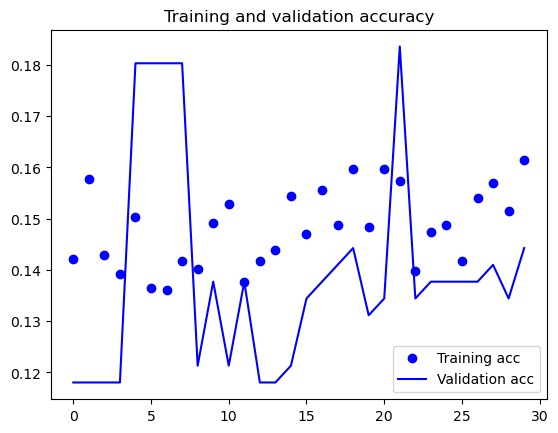

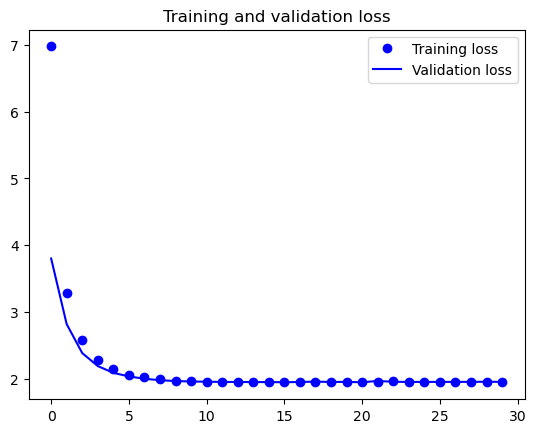

In [143]:
plot_evaluation(history_4)

2023-09-12 14:31:08.345495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 44ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        49
           1     0.1667    0.0256    0.0444        39
           2     0.1124    0.8529    0.1986        34
           3     0.0000    0.0000    0.0000        43
           4     0.1951    0.1569    0.1739        51
           5     0.0000    0.0000    0.0000        35
           6     0.0000    0.0000    0.0000        55

    accuracy                         0.1242       306
   macro avg     0.0677    0.1479    0.0596       306
weighted avg     0.0663    0.1242    0.0567       306



/Users/marysia/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marysia/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marysia/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

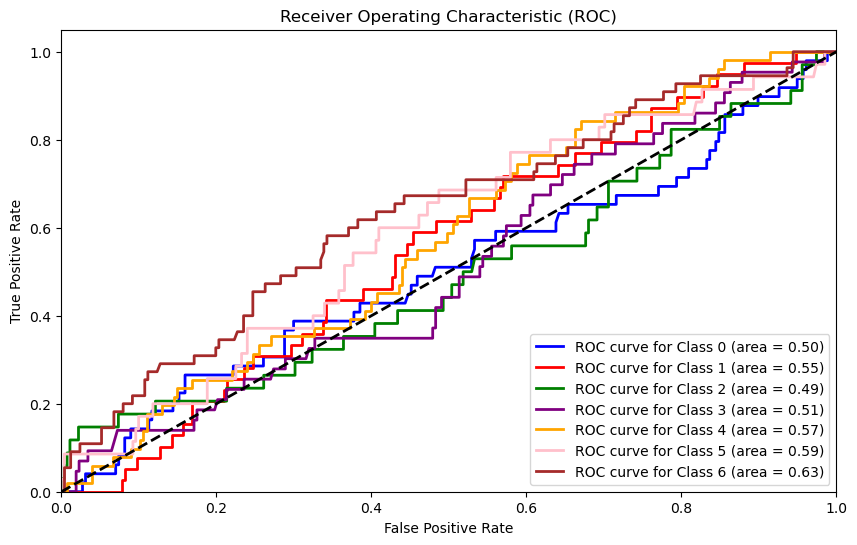

In [144]:
evaluate_model(model_4, X_test, y_test)